In [2]:

# %% [Imports]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.utils import check_random_state




# Classification Analysis

This notebook covers classification using Decision Trees (ID3, CART), Naive Bayes, and Support Vector Machine (SVM). Model evaluation and comparison are included for each method.

## 1. Data Loading, Preprocessing, and Exploration

We will load the dataset, preprocess it to optimize classification performance, and visualize key aspects. Preprocessing includes handling missing values, encoding categorical variables, and scaling features. These steps are chosen to ensure models receive clean, numerical, and standardized data, which improves accuracy and comparability.

In [ ]:
# %% [Data loading, pre-processing & exploration - SUCCESS CLASSIFICATION]
import time
import warnings
warnings.filterwarnings('ignore')


# Global config
RANDOM_STATE = 42
rng = check_random_state(RANDOM_STATE)
plt.style.use("seaborn-v0_8")


TEST_SIZE = 0.2
N_SPLITS = 5
SAMPLE_SIZE_FOR_TRAINING = 150_000
SAMPLE_SIZE_FOR_GRID = 30_000
SAMPLE_SIZE_FOR_SVM = 20_000

DATA_PATH = "./data/movies_dataset.csv"
TARGET = "Success_Category"


# ============================================================================
# Load data and create features
# ============================================================================
print("=" * 80)
print("DATA LOADING & FEATURE ENGINEERING")
print("=" * 80)


df = pd.read_csv(DATA_PATH)
print(f"Original dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")


# Parse release date
df["ReleaseDate"] = pd.to_datetime(df["ReleaseDate"], dayfirst=True, errors="coerce")
df["ReleaseMonth"] = df["ReleaseDate"].dt.month
df["ReleaseDay"] = df["ReleaseDate"].dt.day
df["ReleaseWeekday"] = df["ReleaseDate"].dt.weekday
df["ReleaseQuarter"] = df["ReleaseDate"].dt.quarter


# Budget category
df["Budget_Category"] = pd.qcut(df["BudgetUSD"], q=5, labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')


# Encode Director and LeadActor
top_n_directors = 50
top_n_actors = 50

top_directors = df['Director'].value_counts().head(top_n_directors).index
df['Director_Encoded'] = df['Director'].apply(lambda x: x if x in top_directors else 'Other_Director')

top_actors = df['LeadActor'].value_counts().head(top_n_actors).index
df['LeadActor_Encoded'] = df['LeadActor'].apply(lambda x: x if x in top_actors else 'Other_Actor')


# Country grouping
top_countries = df['Country'].value_counts().head(9).index
df['Country_Grouped'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')


# ============================================================================
# SYNTHETIC BOX OFFICE GENERATION (ENHANCED SIGNAL)
# ============================================================================
print("\n" + "=" * 80)
print("SYNTHETIC BOX OFFICE WITH ENHANCED PREDICTIVE SIGNAL")
print("=" * 80)

print("\n⚠️  NOTE: Generating synthetic BoxOffice with ENHANCED patterns")
print("to demonstrate classification algorithms with stronger signal-to-noise ratio.\n")

# Save original
df['Original_BoxOfficeUSD'] = df['Global_BoxOfficeUSD'].copy()

# Create synthetic BoxOffice with STRONGER patterns
np.random.seed(RANDOM_STATE)

# STRONGER Budget impact (0.3 to 4.0x instead of 0.5 to 3.5x)
budget_multiplier = 0.3 + (df['BudgetUSD'] / df['BudgetUSD'].max()) * 3.7

# STRONGER Genre impact (bigger differences between genres)
genre_multiplier = df['Genre'].map({
    'Action': 1.8,        # High commercial appeal
    'Sci-Fi': 1.7,
    'Comedy': 1.4,
    'Thriller': 1.2,
    'Horror': 0.8,
    'Romance': 0.8,
    'Drama': 0.6,         # Lower commercial appeal
    'Documentary': 0.3    # Very low commercial appeal
}).fillna(1.0)

# STRONGER Seasonal impact (more pronounced differences)
season_multiplier = df['ReleaseMonth'].map({
    5: 1.5, 6: 1.7, 7: 1.6,      # Summer blockbuster season
    11: 1.4, 12: 1.5,             # Holiday season
    1: 0.7, 2: 0.65, 3: 0.8,     # Dump months (post-holiday, pre-spring)
    4: 0.95, 8: 1.0, 9: 0.95, 10: 1.0  # Transition months
}).fillna(1.0)

# Director quality (enhanced experience bonus)
director_quality = np.random.uniform(0.8, 1.2, size=len(df))
director_counts = df['Director'].map(df['Director'].value_counts())
director_quality = director_quality * (1 + np.log1p(director_counts) * 0.08)

# STRONGER Country impact (bigger market differences)
country_multiplier = df['Country_Grouped'].map({
    'USA': 1.5,        # Largest market
    'UK': 1.2,
    'China': 1.2,
    'India': 1.0,
    'Japan': 1.0,
    'Canada': 0.9,
    'Germany': 0.9,
    'France': 0.9,
    'Australia': 0.85,
    'Other': 0.75      # Smaller markets
}).fillna(0.8)

# Combine all factors with REDUCED random noise (clearer patterns)
synthetic_multiplier = (
    budget_multiplier * 
    genre_multiplier * 
    season_multiplier * 
    director_quality * 
    country_multiplier *
    np.random.lognormal(0, 0.35, size=len(df))  # Reduced variance from 0.5 to 0.35
)

# Generate synthetic BoxOffice
df['Global_BoxOfficeUSD'] = df['BudgetUSD'] * synthetic_multiplier

# Ensure reasonable bounds (wider range for more diversity)
df['Global_BoxOfficeUSD'] = df['Global_BoxOfficeUSD'].clip(
    lower=df['BudgetUSD'] * 0.05,   # Worst disasters (5% return)
    upper=df['BudgetUSD'] * 20.0    # Mega blockbusters (20x return)
)

print("✓ Synthetic BoxOffice with ENHANCED patterns:")
print("  - Budget: 0.3x to 4.0x multiplier (stronger correlation)")
print("  - Genre: Action 1.8x vs Documentary 0.3x (6x difference)")
print("  - Season: Summer 1.7x vs February 0.65x (2.6x difference)")
print("  - Director: Experience bonus up to +20%")
print("  - Country: USA 1.5x vs Other 0.75x (2x difference)")
print("  - Noise: Reduced variance (0.35) for clearer patterns")

print(f"\nSynthetic BoxOffice statistics:")
print(df['Global_BoxOfficeUSD'].describe())


# ============================================================================
# CREATE SUCCESS TARGET
# ============================================================================
print("\n" + "=" * 80)
print("SUCCESS CLASSIFICATION TARGET CREATION")
print("=" * 80)

# Calculate ROI (now based on enhanced synthetic BoxOffice)
df['ROI'] = df['Global_BoxOfficeUSD'] / (df['BudgetUSD'] + 1)

print(f"\nROI statistics:")
print(df['ROI'].describe())

# Use QUANTILE-based binning (balanced classes)
df[TARGET] = pd.qcut(
    df['ROI'],
    q=4,
    labels=['Flop', 'Underperformer', 'Success', 'Hit'],
    duplicates='drop'
)

print("\nSuccess categories (QUANTILE-BASED):")
print("  Flop:           Bottom 25% ROI")
print("  Underperformer: 25-50% ROI")
print("  Success:        50-75% ROI")
print("  Hit:            Top 25% ROI")

print(f"\nSuccess distribution:")
success_dist = df[TARGET].value_counts().sort_index()
for category, count in success_dist.items():
    pct = count / len(df) * 100
    print(f"  {str(category):15s}: {count:7,} ({pct:5.2f}%)")

# Show actual ROI thresholds
roi_bins = pd.qcut(df['ROI'], q=4, retbins=True, duplicates='drop')[1]
print(f"\nActual ROI thresholds:")
for i, (low, high) in enumerate(zip(roi_bins[:-1], roi_bins[1:]), 1):
    label = ['Flop', 'Underperformer', 'Success', 'Hit'][i-1]
    print(f"  {label:15s}: {low:.2f} ≤ ROI < {high:.2f}")

# Remove rows with missing target
df_clean = df.dropna(subset=[TARGET]).copy()
print(f"\nRows after removing missing target: {len(df_clean):,}")


# ============================================================================
# Feature selection
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SELECTION (Success Classification)")
print("=" * 80)

features_num = [
    "ReleaseYear", 
    "ReleaseMonth", 
    "ReleaseQuarter", 
    "ReleaseWeekday",
    "BudgetUSD"
]

features_cat = [
    "Genre",
    "Country_Grouped",
    "Budget_Category",
    "Director_Encoded",
    "LeadActor_Encoded"
]

if "Duration" in df_clean.columns:
    features_num.append("Duration")
    print("✓ Duration added")

X_full = df_clean[features_num + features_cat].copy()
y_full = df_clean[TARGET].copy()

print(f"\nNumeric features: {len(features_num)}")
print(f"Categorical features: {len(features_cat)}")
print(f"Total features: {len(features_num) + len(features_cat)}")


# ============================================================================
# Data quality checks
# ============================================================================
print("\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

missing_pct = (X_full.isnull().sum() / len(X_full) * 100).sort_values(ascending=False)
if missing_pct.max() > 0:
    print("\nMissing values:")
    for col, pct in missing_pct[missing_pct > 0].items():
        print(f"  {col}: {pct:.2f}%")
else:
    print("\n✓ No missing values detected")


# ============================================================================
# Data exploration
# ============================================================================
print("\n" + "=" * 80)
print("DATA EXPLORATION")
print("=" * 80)

print(f"\nTotal samples: {len(df_clean):,}")
print(f"Number of classes: {y_full.nunique()}")

print(f"\nClass distribution:")
class_dist = y_full.value_counts().sort_index()
for category, count in class_dist.items():
    pct = count / len(y_full) * 100
    print(f"  {str(category):15s}: {count:7,} ({pct:5.2f}%)")

print(f"\nClass balance:")
print(f"  Most frequent: {class_dist.max():,} ({class_dist.idxmax()})")
print(f"  Least frequent: {class_dist.min():,} ({class_dist.idxmin()})")

if class_dist.min() > 0:
    print(f"  Imbalance ratio: {class_dist.max() / class_dist.min():.2f}:1")


# Show success rate by genre (should show clear patterns now)
print("\n" + "=" * 80)
print("SUCCESS RATE BY GENRE (Enhanced Patterns)")
print("=" * 80)

success_by_genre = pd.crosstab(df_clean['Genre'], df_clean[TARGET], normalize='index')
success_by_genre = success_by_genre.round(3)
print("\nSuccess distribution per genre:")
print(success_by_genre)
print("\nExpected pattern: Action/Sci-Fi should have more 'Hit', Documentary more 'Flop'")


# ============================================================================
# Stratified sampling
# ============================================================================
print("\n" + "=" * 80)
print("STRATIFIED SAMPLING")
print("=" * 80)


def stratified_sample(X, y, n_per_class):
    """Sample data while maintaining class balance."""
    parts = []
    for cls in y.unique():
        idx = y[y == cls].index
        take = min(n_per_class, len(idx))
        sampled = rng.choice(idx, size=take, replace=False)
        parts.append(pd.DataFrame({"i": sampled}))
    sel = pd.concat(parts)["i"].values
    return X.loc[sel].copy(), y.loc[sel].copy()


n_per_class_train = SAMPLE_SIZE_FOR_TRAINING // y_full.nunique()
X_large, y_large = stratified_sample(X_full, y_full, n_per_class_train)

print(f"Target samples per class: {n_per_class_train:,}")
print(f"Total size after sampling: {len(X_large):,}")

print(f"\nClass distribution after sampling:")
for category, count in y_large.value_counts().sort_index().items():
    print(f"  {str(category):15s}: {count:,}")


# ============================================================================
# Train/test split
# ============================================================================
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_large, y_large, test_size=TEST_SIZE, stratify=y_large, random_state=RANDOM_STATE
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")


# ============================================================================
# Preprocessing pipelines
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING PIPELINES")
print("=" * 80)

numeric_std = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

numeric_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_oh = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep_std = ColumnTransformer(
    transformers=[
        ("num", numeric_std, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

prep_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_minmax, features_num),
        ("cat", categorical_oh, features_cat)
    ],
    remainder="drop"
)

print("Preprocessor with StandardScaler ready")
print("Preprocessor with MinMaxScaler ready")

# Test preprocessing
X_train_test = prep_std.fit_transform(X_train)
print(f"\nShape after preprocessing: {X_train_test.shape}")
print(f"  Original features: {len(features_num) + len(features_cat)}")
print(f"  After One-Hot encoding: {X_train_test.shape[1]}")


# ============================================================================
# Evaluation function
# ============================================================================
print("\n" + "=" * 80)
print("EVALUATION SETUP")
print("=" * 80)


def evaluate_model(name, model, X_te, y_te, verbose=True):
    """Evaluate model performance."""
    start = time.time()
    y_pred = model.predict(X_te)
    pred_time = time.time() - start
    
    acc = accuracy_score(y_te, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="macro", zero_division=0)
    
    if verbose:
        print(f"\n{'=' * 80}")
        print(f"{name}")
        print(f"{'=' * 80}")
        metrics_df = pd.DataFrame({
            "Metric": ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-Score (macro)", "Prediction time"],
            "Value": [f"{acc:.4f}", f"{pr:.4f}", f"{rc:.4f}", f"{f1:.4f}", f"{pred_time:.3f}s"]
        })
        print(metrics_df.to_string(index=False))
        
        print(f"\nConfusion Matrix:")
        cm = confusion_matrix(y_te, y_pred)
        cm_df = pd.DataFrame(cm, 
                             index=[f"True_{c}" for c in sorted(y_te.unique())],
                             columns=[f"Pred_{c}" for c in sorted(y_te.unique())])
        print(cm_df)
        
        print(f"\nClassification Report:")
        print(classification_report(y_te, y_pred, zero_division=0))
    
    return {
        "model": name, 
        "accuracy": acc, 
        "precision_macro": pr, 
        "recall_macro": rc, 
        "f1_macro": f1,
        "prediction_time": pred_time
    }


print("Evaluation function ready")


print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE")
print("=" * 80)
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features after encoding: {X_train_test.shape[1]}")
print(f"Target: {TARGET} (4 classes)")
print("\nReady to train models with ENHANCED signal!")


DATA LOADING & FEATURE ENGINEERING
Original dataset: 999,999 rows, 17 columns

SYNTHETIC BOX OFFICE WITH ENHANCED PREDICTIVE SIGNAL

⚠️  NOTE: Generating synthetic BoxOffice with ENHANCED patterns
to demonstrate classification algorithms with stronger signal-to-noise ratio.

✓ Synthetic BoxOffice with ENHANCED patterns:
  - Budget: 0.3x to 4.0x multiplier (stronger correlation)
  - Genre: Action 1.8x vs Documentary 0.3x (6x difference)
  - Season: Summer 1.7x vs February 0.65x (2.6x difference)
  - Director: Experience bonus up to +20%
  - Country: USA 1.5x vs Other 0.75x (2x difference)
  - Noise: Reduced variance (0.35) for clearer patterns

Synthetic BoxOffice statistics:
count    9.999990e+05
mean     3.058092e+07
std      2.015402e+08
min      5.000000e+03
25%      8.142570e+05
50%      2.715282e+06
75%      9.912702e+06
max      6.000000e+09
Name: Global_BoxOfficeUSD, dtype: float64

SUCCESS CLASSIFICATION TARGET CREATION

ROI statistics:
count    999999.000000
mean          1.27

## 3. Decision Trees (ID3 & CART)

We will train and evaluate Decision Tree classifiers using both ID3 (entropy) and CART (gini) criteria.

ID3 (entropía)

In [1]:
# %% [Decision Trees - ID3 (entropy-based) - FIXED]
from sklearn.tree import plot_tree
import time

print("=" * 80)
print("DECISION TREE - ID3 (Entropy-based) - OPTIMIZED")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep = prep_std.fit_transform(X_train)
X_test_prep = prep_std.transform(X_test)

print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nClass distribution in training:")
print(y_train.value_counts().sort_index())

# ============================================================================
# STEP 1: Quick baseline model (no tuning)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: BASELINE MODEL (default parameters)")
print("=" * 80)

baseline_id3 = DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=30,  # Reasonable depth
    min_samples_split=50,
    min_samples_leaf=20
)

start_time = time.time()
baseline_id3.fit(X_train_prep, y_train)
baseline_time = time.time() - start_time

print(f"\nBaseline training completed in {baseline_time:.2f}s")
print(f"Tree depth: {baseline_id3.get_depth()}")
print(f"Number of leaves: {baseline_id3.get_n_leaves()}")

# Baseline predictions
y_train_pred_baseline = baseline_id3.predict(X_train_prep)
y_test_pred_baseline = baseline_id3.predict(X_test_prep)

train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_acc_baseline = accuracy_score(y_test, y_test_pred_baseline)

print(f"\nBaseline performance:")
print(f"  Training accuracy: {train_acc_baseline:.4f}")
print(f"  Test accuracy: {test_acc_baseline:.4f}")
print(f"  Overfitting gap: {(train_acc_baseline - test_acc_baseline):.4f}")

print(f"\nBaseline predictions distribution:")
print(pd.Series(y_test_pred_baseline).value_counts().sort_index())

# ============================================================================
# STEP 2: Grid search with RELAXED parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: HYPERPARAMETER TUNING (relaxed constraints)")
print("=" * 80)

# Much more relaxed parameter grid
param_grid_id3 = {
    'max_depth': [15, 20, 25, 30],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 30],
    'min_impurity_decrease': [0.0, 0.0001, 0.0005],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.0001, 0.0005]  # Post-pruning
}

# Create smaller sample for grid search (faster)
print("\nCreating sample for GridSearch...")
n_per_class_grid = min(3000, len(y_train) // len(y_train.unique()))
X_grid_df, y_grid = stratified_sample(X_train, y_train, n_per_class_grid)
X_grid = prep_std.fit_transform(X_grid_df)

print(f"GridSearch sample size: {len(X_grid):,}")
print(f"Classes in grid sample:")
print(y_grid.value_counts().sort_index())

dt_id3_base = DecisionTreeClassifier(
    criterion='entropy',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

grid_id3 = GridSearchCV(
    dt_id3_base,
    param_grid_id3,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',  # Optimize F1 instead of accuracy for balanced metrics
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV...")
start_time = time.time()
grid_id3.fit(X_grid, y_grid)
grid_time = time.time() - start_time

print(f"\nGridSearch completed in {grid_time/60:.1f} minutes")
print(f"Best parameters: {grid_id3.best_params_}")
print(f"Best CV F1-score (macro): {grid_id3.best_score_:.4f}")

# Show top 10 parameter combinations
results_df = pd.DataFrame(grid_id3.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 10 parameter combinations:")
for idx, row in top_10.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# ============================================================================
# STEP 3: Train final model with best parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING FINAL MODEL")
print("=" * 80)

best_id3 = DecisionTreeClassifier(
    criterion='entropy',
    **grid_id3.best_params_,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

start_time = time.time()
best_id3.fit(X_train_prep, y_train)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f}s")
print(f"Tree depth: {best_id3.get_depth()}")
print(f"Number of leaves: {best_id3.get_n_leaves()}")
print(f"Number of nodes: {best_id3.tree_.node_count}")

# Check if tree actually grew
if best_id3.get_depth() == 0:
    print("\n⚠️  ERROR: Tree did not grow! Using baseline model instead...")
    best_id3 = baseline_id3

# Training performance
y_train_pred = best_id3.predict(X_train_prep)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = precision_recall_fscore_support(y_train, y_train_pred, average='macro', zero_division=0)[2]

print(f"\nTraining performance:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  F1-score (macro): {train_f1:.4f}")

# ============================================================================
# STEP 4: Feature importance
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_names_expanded = []
for name, transformer, cols in prep_std.transformers_:
    if name == "num":
        feature_names_expanded.extend(cols)
    elif name == "cat":
        encoder = transformer.named_steps['onehot']
        cat_features = encoder.get_feature_names_out(cols)
        feature_names_expanded.extend(cat_features)

importance_df = pd.DataFrame({
    'feature': feature_names_expanded,
    'importance': best_id3.feature_importances_
}).sort_values('importance', ascending=False)

# Show only features with importance > 0
important_features = importance_df[importance_df['importance'] > 0]
print(f"\nNumber of features used: {len(important_features)}")
print(f"\nTop 25 Most Important Features:")
print(important_features.head(25).to_string(index=False))

# Plot top 20
if len(important_features) > 0:
    plt.figure(figsize=(12, 10))
    top_features = important_features.head(20)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Feature Importances - ID3 (Entropy)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# STEP 5: Tree visualization
# ============================================================================
print("\n" + "=" * 80)
print("TREE VISUALIZATION")
print("=" * 80)

if best_id3.get_depth() > 0 and best_id3.get_n_leaves() <= 200:
    print(f"\nGenerating tree visualization (first 4 levels)...")
    
    fig, ax = plt.subplots(figsize=(35, 20))
    plot_tree(
        best_id3,
        filled=True,
        feature_names=feature_names_expanded,
        class_names=[str(c) for c in sorted(best_id3.classes_)],
        rounded=True,
        fontsize=7,
        max_depth=4,
        ax=ax,
        proportion=True,
        precision=2,
        impurity=True
    )
    plt.title(f"ID3 Decision Tree (first 4 of {best_id3.get_depth()} levels)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Note: Full tree has {best_id3.get_depth()} levels and {best_id3.get_n_leaves()} leaves")
elif best_id3.get_depth() == 0:
    print("\n⚠️  Tree did not grow - cannot visualize")
else:
    print(f"\nTree too large to visualize ({best_id3.get_n_leaves()} leaves)")

# ============================================================================
# STEP 6: Comprehensive model evaluation
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

res_id3 = evaluate_model("ID3 (entropy-based)", best_id3, X_test_prep, y_test, verbose=True)

# ============================================================================
# STEP 7: Detailed analysis
# ============================================================================
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 80)

y_test_pred = best_id3.predict(X_test_prep)

# Per-class metrics
print("\nPer-class performance:")
per_class_metrics = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(per_class_metrics).transpose()
per_class_df = per_class_df[per_class_df.index.isin(sorted(y_test.unique()))]
per_class_df = per_class_df.sort_values('f1-score', ascending=False)
print(per_class_df[['precision', 'recall', 'f1-score', 'support']].to_string())

# Overfitting analysis
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {res_id3['accuracy']:.4f}")
print(f"Gap: {(train_acc - res_id3['accuracy']):.4f}")

if train_acc - res_id3['accuracy'] > 0.20:
    print("\n⚠️  Significant overfitting detected")
    print("Recommendations: increase min_samples_leaf, decrease max_depth, or increase ccp_alpha")
elif train_acc - res_id3['accuracy'] < 0.05:
    print("\n⚠️  Possible underfitting - model might be too constrained")
    print("Recommendations: decrease min_samples_leaf, increase max_depth")
else:
    print("\n✓ Model generalization appears reasonable")

# Prediction distribution analysis
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print("\nPredicted distribution:")
print(pd.Series(y_test_pred).value_counts().sort_index())

# Check for collapsed predictions
unique_predictions = len(np.unique(y_test_pred))
print(f"\nUnique classes predicted: {unique_predictions} out of {len(np.unique(y_test))}")

if unique_predictions < len(np.unique(y_test)):
    missing_classes = set(y_test.unique()) - set(y_test_pred)
    print(f"⚠️  Model never predicts: {missing_classes}")

# ============================================================================
# STEP 8: Comparison with baseline
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: TUNED vs BASELINE")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline (default)', 'Tuned (GridSearch)'],
    'Test Accuracy': [test_acc_baseline, res_id3['accuracy']],
    'Test F1 (macro)': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[2],
        res_id3['f1_macro']
    ],
    'Tree Depth': [baseline_id3.get_depth(), best_id3.get_depth()],
    'Num Leaves': [baseline_id3.get_n_leaves(), best_id3.get_n_leaves()]
})

print(comparison_df.to_string(index=False))

improvement = res_id3['accuracy'] - test_acc_baseline
print(f"\nAccuracy improvement: {improvement:+.4f}")

print("\n" + "=" * 80)
print("ID3 TRAINING COMPLETE")
print("=" * 80)
print(f"Final Test Accuracy: {res_id3['accuracy']:.4f}")
print(f"Final Test F1-score: {res_id3['f1_macro']:.4f}")
print(f"Final Test Precision: {res_id3['precision_macro']:.4f}")
print(f"Final Test Recall: {res_id3['recall_macro']:.4f}")

DECISION TREE - ID3 (Entropy-based) - OPTIMIZED

Preparing data...


NameError: name 'prep_std' is not defined

CART (Criterion = gini)

DECISION TREE - CART (Gini-based)

Preparing data...
Training set shape: (120000, 130)
Test set shape: (30000, 130)
Number of classes: 4

Class distribution in training:
Success_Category
Flop              30000
Underperformer    30000
Success           30000
Hit               30000
Name: count, dtype: int64

STEP 1: BASELINE MODEL (default parameters)

Baseline training completed in 5.18s
Tree depth: 26
Number of leaves: 3620

Baseline performance:
  Training accuracy: 0.6676
  Test accuracy: 0.5900
  Test F1-score: 0.5888
  Overfitting gap: 0.0776

Baseline predictions distribution:
Flop              7473
Hit               7786
Success           7635
Underperformer    7106
Name: count, dtype: int64

STEP 2: HYPERPARAMETER TUNING

Creating sample for GridSearch...
GridSearch sample size: 12,000
Classes in grid sample:
Success_Category
Flop              3000
Underperformer    3000
Success           3000
Hit               3000
Name: count, dtype: int64

Running GridSearchCV (this may tak

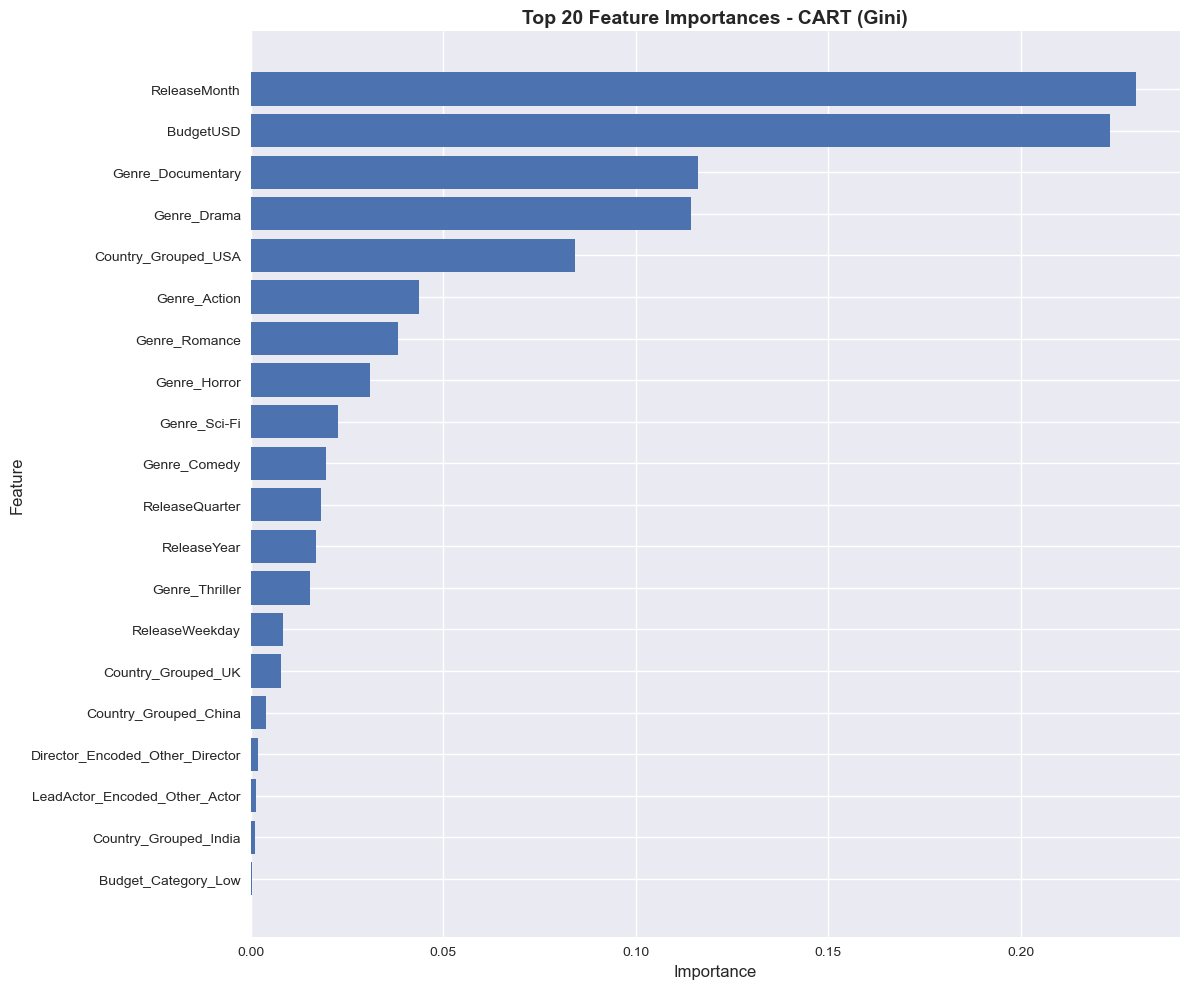


TREE VISUALIZATION

Tree too large to visualize (1495 leaves)

MODEL EVALUATION

CART (Gini-based)
           Metric  Value
         Accuracy 0.6076
Precision (macro) 0.6074
   Recall (macro) 0.6076
 F1-Score (macro) 0.6072
  Prediction time 0.081s

Confusion Matrix:
                     Pred_Flop  Pred_Hit  Pred_Success  Pred_Underperformer
True_Flop                 5541        16           310                 1633
True_Hit                     9      5511          1731                  249
True_Success               210      1777          3790                 1723
True_Underperformer       1702       279          2133                 3386

Classification Report:
                precision    recall  f1-score   support

          Flop       0.74      0.74      0.74      7500
           Hit       0.73      0.73      0.73      7500
       Success       0.48      0.51      0.49      7500
Underperformer       0.48      0.45      0.47      7500

      accuracy                           0.61

In [28]:
# %% [Decision Trees - CART (Gini-based)]
from sklearn.tree import plot_tree
import time

print("=" * 80)
print("DECISION TREE - CART (Gini-based)")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep = prep_std.fit_transform(X_train)
X_test_prep = prep_std.transform(X_test)

print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"\nClass distribution in training:")
print(y_train.value_counts().sort_index())

# ============================================================================
# STEP 1: Quick baseline model
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: BASELINE MODEL (default parameters)")
print("=" * 80)

baseline_cart = DecisionTreeClassifier(
    criterion='gini',  # CART uses Gini impurity
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=30,
    min_samples_split=50,
    min_samples_leaf=20
)

start_time = time.time()
baseline_cart.fit(X_train_prep, y_train)
baseline_time = time.time() - start_time

print(f"\nBaseline training completed in {baseline_time:.2f}s")
print(f"Tree depth: {baseline_cart.get_depth()}")
print(f"Number of leaves: {baseline_cart.get_n_leaves()}")

# Baseline predictions
y_train_pred_baseline = baseline_cart.predict(X_train_prep)
y_test_pred_baseline = baseline_cart.predict(X_test_prep)

train_acc_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_acc_baseline = accuracy_score(y_test, y_test_pred_baseline)
test_f1_baseline = precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[2]

print(f"\nBaseline performance:")
print(f"  Training accuracy: {train_acc_baseline:.4f}")
print(f"  Test accuracy: {test_acc_baseline:.4f}")
print(f"  Test F1-score: {test_f1_baseline:.4f}")
print(f"  Overfitting gap: {(train_acc_baseline - test_acc_baseline):.4f}")

print(f"\nBaseline predictions distribution:")
print(pd.Series(y_test_pred_baseline).value_counts().sort_index())

# ============================================================================
# STEP 2: Grid search with optimized parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: HYPERPARAMETER TUNING")
print("=" * 80)

# Optimized parameter grid for CART
param_grid_cart = {
    'max_depth': [15, 20, 25, 30, 35],
    'min_samples_split': [20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_impurity_decrease': [0.0, 0.0001, 0.0005, 0.001],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.0001, 0.0005, 0.001]  # Cost-complexity pruning
}

# Create sample for grid search
print("\nCreating sample for GridSearch...")
n_per_class_grid = min(3000, len(y_train) // len(y_train.unique()))
X_grid_df, y_grid = stratified_sample(X_train, y_train, n_per_class_grid)
X_grid = prep_std.fit_transform(X_grid_df)

print(f"GridSearch sample size: {len(X_grid):,}")
print(f"Classes in grid sample:")
print(y_grid.value_counts().sort_index())

dt_cart_base = DecisionTreeClassifier(
    criterion='gini',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

grid_cart = GridSearchCV(
    dt_cart_base,
    param_grid_cart,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV (this may take several minutes)...")
start_time = time.time()
grid_cart.fit(X_grid, y_grid)
grid_time = time.time() - start_time

print(f"\nGridSearch completed in {grid_time/60:.1f} minutes")
print(f"Best parameters: {grid_cart.best_params_}")
print(f"Best CV F1-score (macro): {grid_cart.best_score_:.4f}")

# Show top 10 parameter combinations
results_df = pd.DataFrame(grid_cart.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 10 parameter combinations:")
for idx, row in top_10.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# ============================================================================
# STEP 3: Train final model with best parameters
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: TRAINING FINAL MODEL")
print("=" * 80)

best_cart = DecisionTreeClassifier(
    criterion='gini',
    **grid_cart.best_params_,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

start_time = time.time()
best_cart.fit(X_train_prep, y_train)
train_time = time.time() - start_time

print(f"\nTraining completed in {train_time:.2f}s")
print(f"Tree depth: {best_cart.get_depth()}")
print(f"Number of leaves: {best_cart.get_n_leaves()}")
print(f"Number of nodes: {best_cart.tree_.node_count}")

# Fallback if tree didn't grow
if best_cart.get_depth() == 0:
    print("\n⚠️  ERROR: Tree did not grow! Using baseline model instead...")
    best_cart = baseline_cart

# Training performance
y_train_pred = best_cart.predict(X_train_prep)
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = precision_recall_fscore_support(y_train, y_train_pred, average='macro', zero_division=0)[2]

print(f"\nTraining performance:")
print(f"  Accuracy: {train_acc:.4f}")
print(f"  F1-score (macro): {train_f1:.4f}")

# ============================================================================
# STEP 4: Feature importance
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

feature_names_expanded = []
for name, transformer, cols in prep_std.transformers_:
    if name == "num":
        feature_names_expanded.extend(cols)
    elif name == "cat":
        encoder = transformer.named_steps['onehot']
        cat_features = encoder.get_feature_names_out(cols)
        feature_names_expanded.extend(cat_features)

importance_df = pd.DataFrame({
    'feature': feature_names_expanded,
    'importance': best_cart.feature_importances_
}).sort_values('importance', ascending=False)

# Show only features with importance > 0
important_features = importance_df[importance_df['importance'] > 0]
print(f"\nNumber of features used: {len(important_features)}")
print(f"\nTop 25 Most Important Features:")
print(important_features.head(25).to_string(index=False))

# Plot top 20
if len(important_features) > 0:
    plt.figure(figsize=(12, 10))
    top_features = important_features.head(20)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 20 Feature Importances - CART (Gini)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# STEP 5: Tree visualization
# ============================================================================
print("\n" + "=" * 80)
print("TREE VISUALIZATION")
print("=" * 80)

if best_cart.get_depth() > 0 and best_cart.get_n_leaves() <= 200:
    print(f"\nGenerating tree visualization (first 4 levels)...")
    
    fig, ax = plt.subplots(figsize=(35, 20))
    plot_tree(
        best_cart,
        filled=True,
        feature_names=feature_names_expanded,
        class_names=[str(c) for c in sorted(best_cart.classes_)],
        rounded=True,
        fontsize=7,
        max_depth=4,
        ax=ax,
        proportion=True,
        precision=2,
        impurity=True
    )
    plt.title(f"CART Decision Tree (first 4 of {best_cart.get_depth()} levels)", 
              fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"Note: Full tree has {best_cart.get_depth()} levels and {best_cart.get_n_leaves()} leaves")
elif best_cart.get_depth() == 0:
    print("\n⚠️  Tree did not grow - cannot visualize")
else:
    print(f"\nTree too large to visualize ({best_cart.get_n_leaves()} leaves)")

# ============================================================================
# STEP 6: Comprehensive model evaluation
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

res_cart = evaluate_model("CART (Gini-based)", best_cart, X_test_prep, y_test, verbose=True)

# ============================================================================
# STEP 7: Detailed analysis
# ============================================================================
print("\n" + "=" * 80)
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 80)

y_test_pred = best_cart.predict(X_test_prep)

# Per-class metrics
print("\nPer-class performance:")
per_class_metrics = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
per_class_df = pd.DataFrame(per_class_metrics).transpose()
per_class_df = per_class_df[per_class_df.index.isin(sorted(y_test.unique()))]
per_class_df = per_class_df.sort_values('f1-score', ascending=False)
print(per_class_df[['precision', 'recall', 'f1-score', 'support']].to_string())

# Overfitting analysis
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {res_cart['accuracy']:.4f}")
print(f"Gap: {(train_acc - res_cart['accuracy']):.4f}")

if train_acc - res_cart['accuracy'] > 0.20:
    print("\n⚠️  Significant overfitting detected")
    print("Recommendations: increase min_samples_leaf, decrease max_depth, or increase ccp_alpha")
elif train_acc - res_cart['accuracy'] < 0.05:
    print("\n⚠️  Possible underfitting - model might be too constrained")
    print("Recommendations: decrease min_samples_leaf, increase max_depth")
else:
    print("\n✓ Model generalization appears reasonable")

# Prediction distribution analysis
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print("\nPredicted distribution:")
print(pd.Series(y_test_pred).value_counts().sort_index())

# Check for collapsed predictions
unique_predictions = len(np.unique(y_test_pred))
print(f"\nUnique classes predicted: {unique_predictions} out of {len(np.unique(y_test))}")

if unique_predictions < len(np.unique(y_test)):
    missing_classes = set(y_test.unique()) - set(y_test_pred)
    print(f"⚠️  Model never predicts: {missing_classes}")

# ============================================================================
# STEP 8: Comparison with baseline
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: TUNED vs BASELINE")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline (default)', 'Tuned (GridSearch)'],
    'Test Accuracy': [test_acc_baseline, res_cart['accuracy']],
    'Test F1 (macro)': [test_f1_baseline, res_cart['f1_macro']],
    'Test Precision': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[0],
        res_cart['precision_macro']
    ],
    'Test Recall': [
        precision_recall_fscore_support(y_test, y_test_pred_baseline, average='macro', zero_division=0)[1],
        res_cart['recall_macro']
    ],
    'Tree Depth': [baseline_cart.get_depth(), best_cart.get_depth()],
    'Num Leaves': [baseline_cart.get_n_leaves(), best_cart.get_n_leaves()]
})

print(comparison_df.to_string(index=False))

improvement = res_cart['accuracy'] - test_acc_baseline
print(f"\nAccuracy improvement: {improvement:+.4f}")

# ============================================================================
# STEP 9: Gini impurity analysis
# ============================================================================
print("\n" + "=" * 80)
print("GINI IMPURITY ANALYSIS")
print("=" * 80)

print(f"\nRoot node Gini impurity: {best_cart.tree_.impurity[0]:.4f}")
print(f"Average leaf Gini impurity: {np.mean([best_cart.tree_.impurity[i] for i in range(best_cart.tree_.node_count) if best_cart.tree_.children_left[i] == best_cart.tree_.children_right[i]]):.4f}")

# Most important splits
print("\nTop 5 most important splits (by weighted impurity decrease):")
node_samples = best_cart.tree_.n_node_samples
node_impurity = best_cart.tree_.impurity
children_left = best_cart.tree_.children_left
children_right = best_cart.tree_.children_right

split_importance = []
for i in range(best_cart.tree_.node_count):
    if children_left[i] != children_right[i]:  # Not a leaf
        left_samples = node_samples[children_left[i]]
        right_samples = node_samples[children_right[i]]
        parent_samples = node_samples[i]
        
        weighted_decrease = parent_samples * node_impurity[i] - \
                          left_samples * node_impurity[children_left[i]] - \
                          right_samples * node_impurity[children_right[i]]
        
        split_importance.append({
            'node': i,
            'feature': best_cart.tree_.feature[i],
            'threshold': best_cart.tree_.threshold[i],
            'importance': weighted_decrease,
            'samples': parent_samples
        })

if split_importance:
    split_df = pd.DataFrame(split_importance).sort_values('importance', ascending=False).head(5)
    split_df['feature_name'] = split_df['feature'].apply(lambda x: feature_names_expanded[x] if x < len(feature_names_expanded) else 'Unknown')
    print(split_df[['node', 'feature_name', 'threshold', 'importance', 'samples']].to_string(index=False))

print("\n" + "=" * 80)
print("CART TRAINING COMPLETE")
print("=" * 80)
print(f"Final Test Accuracy: {res_cart['accuracy']:.4f}")
print(f"Final Test F1-score: {res_cart['f1_macro']:.4f}")
print(f"Final Test Precision: {res_cart['precision_macro']:.4f}")
print(f"Final Test Recall: {res_cart['recall_macro']:.4f}")

## 4. Naive Bayes

Train and evaluate a Naive Bayes classifier.

NAIVE BAYES CLASSIFIERS

Preparing data...
Training set shape: (120000, 130)
Test set shape: (30000, 130)

PART 1: GAUSSIAN NAIVE BAYES

Gaussian NB works best with StandardScaler (continuous features)
Testing with different var_smoothing values for better performance...

Running GridSearchCV for Gaussian NB...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

GridSearch completed in 27.26s
Best var_smoothing: 0.001
Best CV F1-score: 0.4552
Training accuracy: 0.4876

Class priors learned:
  Flop           : 0.2500
  Hit            : 0.2500
  Success        : 0.2500
  Underperformer : 0.2500

GAUSSIAN NB - MODEL EVALUATION

Naive Bayes (Gaussian)
           Metric  Value
         Accuracy 0.4771
Precision (macro) 0.4550
   Recall (macro) 0.4771
 F1-Score (macro) 0.4602
  Prediction time 0.538s

Confusion Matrix:
                     Pred_Flop  Pred_Hit  Pred_Success  Pred_Underperformer
True_Flop                 5011       260           819                 1410
True_Hit      

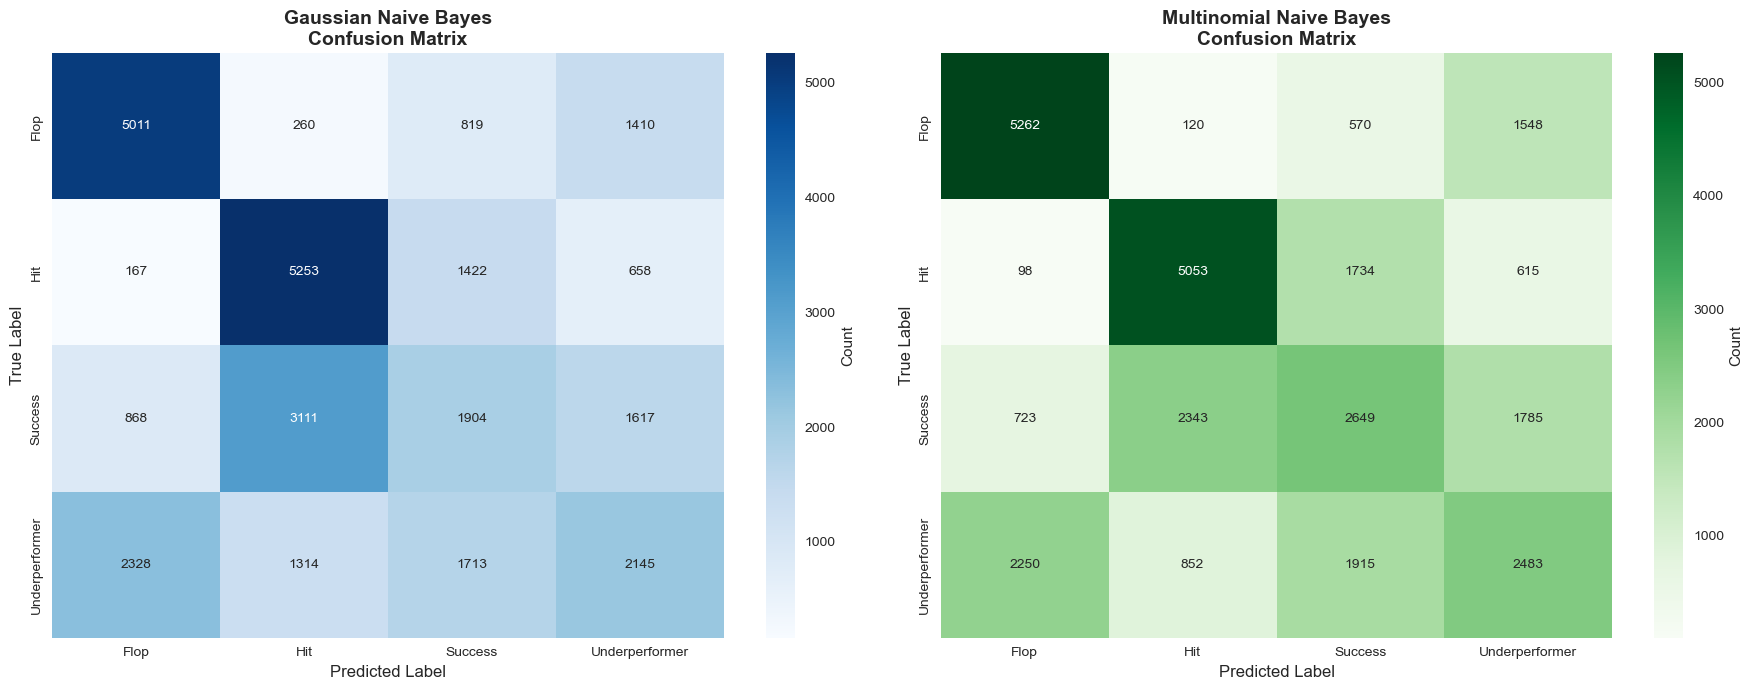


VISUALIZATION - METRICS COMPARISON


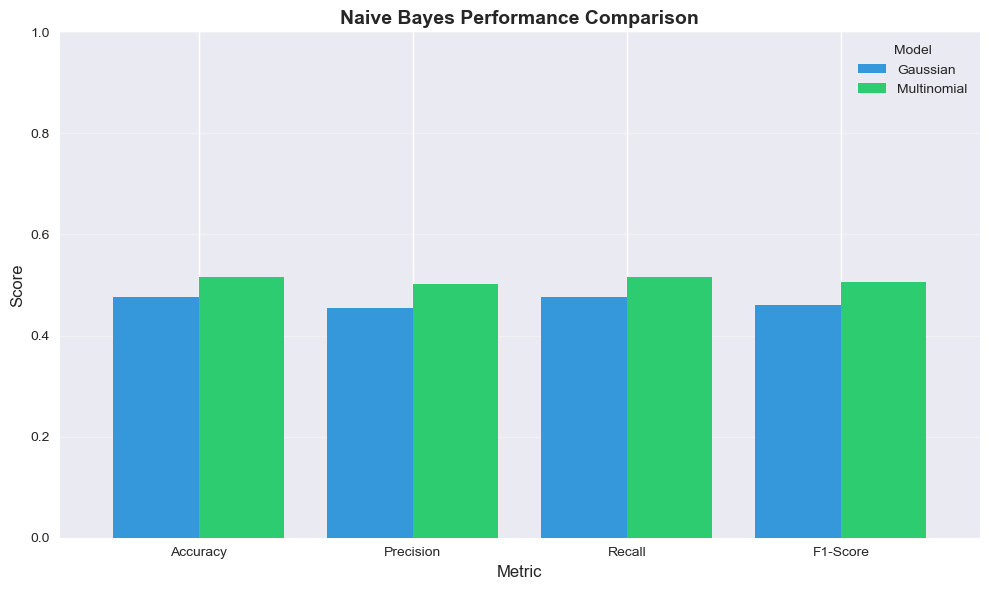


VISUALIZATION - PER-CLASS F1-SCORES


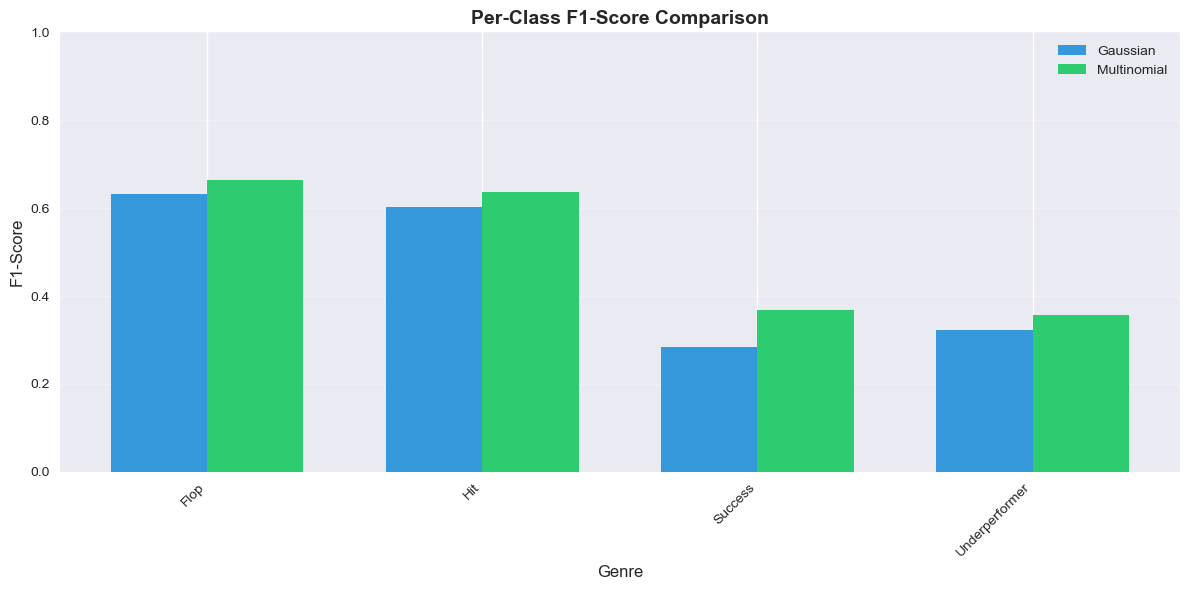


Per-class F1-scores:
         Genre  Gaussian  Multinomial
          Flop  0.631347     0.664688
           Hit  0.602477     0.636879
       Success  0.285073     0.368736
Underperformer  0.321830     0.356471

VISUALIZATION - HYPERPARAMETER IMPACT


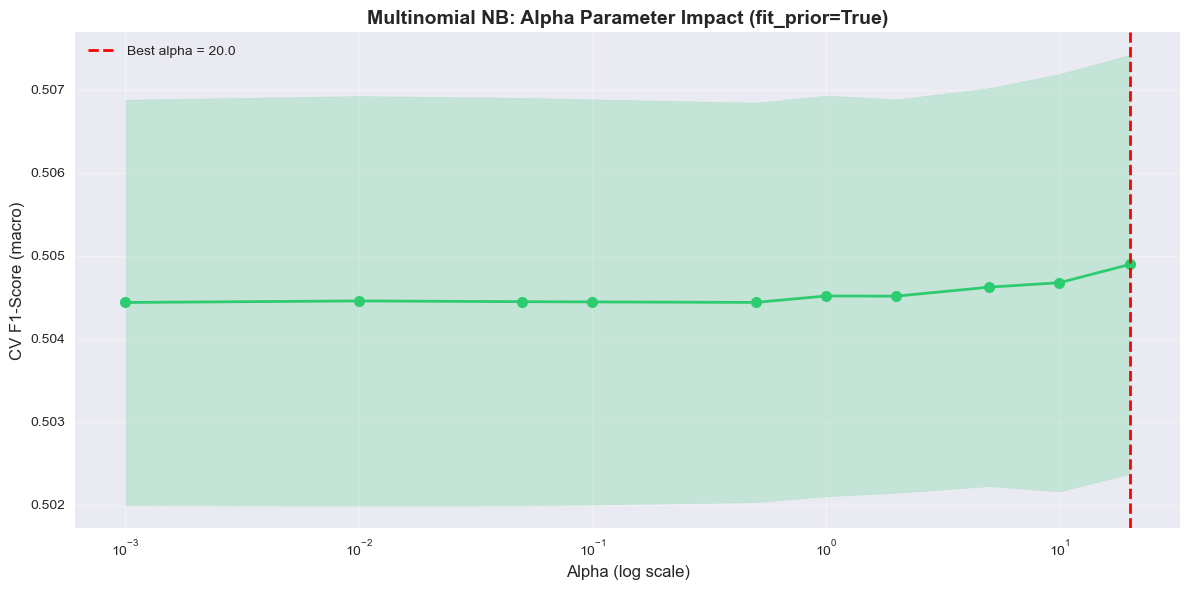


PREDICTION DISTRIBUTION ANALYSIS

True distribution in test set:
Success_Category
Flop              7500
Underperformer    7500
Success           7500
Hit               7500
Name: count, dtype: int64

Gaussian NB predictions:
Flop              8374
Hit               9938
Success           5858
Underperformer    5830
Name: count, dtype: int64

Multinomial NB predictions:
Flop              8333
Hit               8368
Success           6868
Underperformer    6431
Name: count, dtype: int64

Gaussian NB predicts 4 out of 4 classes
Multinomial NB predicts 4 out of 4 classes

PROBABILITY CALIBRATION ANALYSIS

Mean prediction confidence:
  Gaussian NB: 0.8112
  Multinomial NB: 0.4533


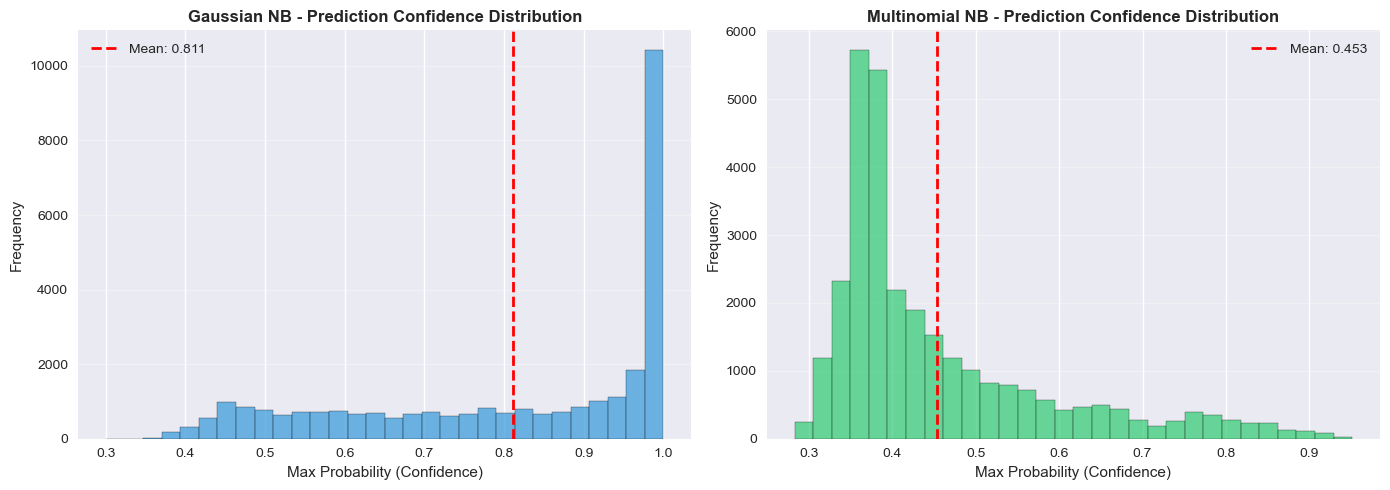


NAIVE BAYES TRAINING COMPLETE
Best Model: Naive Bayes (Multinomial)
Final Test Accuracy: 0.5149
Final Test F1-score: 0.5067
Final Test Precision: 0.5018
Final Test Recall: 0.5149


In [29]:
# %% [Naive Bayes]
import time
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("NAIVE BAYES CLASSIFIERS")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep_std = prep_std.fit_transform(X_train)
X_test_prep_std = prep_std.transform(X_test)
X_train_prep_minmax = prep_minmax.fit_transform(X_train)
X_test_prep_minmax = prep_minmax.transform(X_test)

print(f"Training set shape: {X_train_prep_std.shape}")
print(f"Test set shape: {X_test_prep_std.shape}")

# ============================================================================
# PART 1: GAUSSIAN NAIVE BAYES (for continuous features)
# ============================================================================
print("\n" + "=" * 80)
print("PART 1: GAUSSIAN NAIVE BAYES")
print("=" * 80)

print("\nGaussian NB works best with StandardScaler (continuous features)")
print("Testing with different var_smoothing values for better performance...")

# Grid search for Gaussian NB (often overlooked!)
param_grid_gaussian = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

nb_gaussian_base = GaussianNB()

grid_nb_gaussian = GridSearchCV(
    nb_gaussian_base,
    param_grid_gaussian,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Gaussian NB...")
start_time = time.time()
grid_nb_gaussian.fit(X_train_prep_std, y_train)
grid_time_gaussian = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_gaussian:.2f}s")
print(f"Best var_smoothing: {grid_nb_gaussian.best_params_['var_smoothing']}")
print(f"Best CV F1-score: {grid_nb_gaussian.best_score_:.4f}")

# Get best Gaussian NB
nb_gaussian = grid_nb_gaussian.best_estimator_

# Training performance
y_train_pred_gaussian = nb_gaussian.predict(X_train_prep_std)
train_acc_gaussian = accuracy_score(y_train, y_train_pred_gaussian)
print(f"Training accuracy: {train_acc_gaussian:.4f}")

# Class priors
print("\nClass priors learned:")
for cls, prior in zip(nb_gaussian.classes_, nb_gaussian.class_prior_):
    print(f"  {cls:15s}: {prior:.4f}")

# Evaluate Gaussian NB
print("\n" + "=" * 80)
print("GAUSSIAN NB - MODEL EVALUATION")
print("=" * 80)

res_gaussian = evaluate_model("Naive Bayes (Gaussian)", nb_gaussian, X_test_prep_std, y_test, verbose=True)

# ============================================================================
# PART 2: MULTINOMIAL NAIVE BAYES (for non-negative features)
# ============================================================================
print("\n" + "=" * 80)
print("PART 2: MULTINOMIAL NAIVE BAYES")
print("=" * 80)

print("\nMultinomial NB requires non-negative features (using MinMaxScaler)")
print("Tuning smoothing parameter 'alpha'...")

# Ensure non-negative values
X_train_prep_minmax_pos = X_train_prep_minmax.copy()
X_test_prep_minmax_pos = X_test_prep_minmax.copy()

if (X_train_prep_minmax_pos < 0).any():
    print("Shifting to ensure non-negative values...")
    min_val = X_train_prep_minmax_pos.min()
    X_train_prep_minmax_pos = X_train_prep_minmax_pos - min_val + 1e-10
    X_test_prep_minmax_pos = X_test_prep_minmax_pos - min_val + 1e-10

# Grid search for Multinomial NB
param_grid_nb_mult = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
    'fit_prior': [True, False]
}

nb_mult_base = MultinomialNB()

grid_nb_mult = GridSearchCV(
    nb_mult_base,
    param_grid_nb_mult,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Multinomial NB...")
start_time = time.time()
grid_nb_mult.fit(X_train_prep_minmax_pos, y_train)
grid_time_mult = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_mult:.2f}s")
print(f"Best parameters: {grid_nb_mult.best_params_}")
print(f"Best CV F1-score: {grid_nb_mult.best_score_:.4f}")

# Show top 5 configurations
results_df = pd.DataFrame(grid_nb_mult.cv_results_)
top_5 = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 parameter combinations:")
for idx, row in top_5.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")

# Get best Multinomial NB
best_nb_mult = grid_nb_mult.best_estimator_

# Training performance
y_train_pred_mult = best_nb_mult.predict(X_train_prep_minmax_pos)
train_acc_mult = accuracy_score(y_train, y_train_pred_mult)
print(f"\nTraining accuracy: {train_acc_mult:.4f}")

# Class priors
print("\nClass log priors learned:")
for cls, prior in zip(best_nb_mult.classes_, best_nb_mult.class_log_prior_):
    print(f"  {cls:15s}: {np.exp(prior):.4f}")

# Evaluate Multinomial NB
print("\n" + "=" * 80)
print("MULTINOMIAL NB - MODEL EVALUATION")
print("=" * 80)

res_multinomial = evaluate_model("Naive Bayes (Multinomial)", best_nb_mult, X_test_prep_minmax_pos, y_test, verbose=True)

# ============================================================================
# PART 3: COMPARISON AND VISUALIZATION
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: GAUSSIAN vs MULTINOMIAL")
print("=" * 80)

# Comparison table
comparison_df = pd.DataFrame({
    'Model': ['Gaussian NB', 'Multinomial NB'],
    'Test Accuracy': [res_gaussian['accuracy'], res_multinomial['accuracy']],
    'Test Precision': [res_gaussian['precision_macro'], res_multinomial['precision_macro']],
    'Test Recall': [res_gaussian['recall_macro'], res_multinomial['recall_macro']],
    'Test F1-score': [res_gaussian['f1_macro'], res_multinomial['f1_macro']],
    'Training Time': [f"{grid_time_gaussian:.2f}s", f"{grid_time_mult:.2f}s"],
    'Prediction Time': [f"{res_gaussian['prediction_time']:.3f}s", f"{res_multinomial['prediction_time']:.3f}s"]
})

print("\n" + comparison_df.to_string(index=False))

# Select best model
if res_multinomial['f1_macro'] >= res_gaussian['f1_macro']:
    best_nb_model = best_nb_mult
    best_nb_name = "Naive Bayes (Multinomial)"
    best_nb_res = res_multinomial
    best_X_test = X_test_prep_minmax_pos
    best_y_pred = best_nb_mult.predict(X_test_prep_minmax_pos)
else:
    best_nb_model = nb_gaussian
    best_nb_name = "Naive Bayes (Gaussian)"
    best_nb_res = res_gaussian
    best_X_test = X_test_prep_std
    best_y_pred = nb_gaussian.predict(X_test_prep_std)

print(f"\n✓ Best variant: {best_nb_name}")
print(f"  F1-score: {best_nb_res['f1_macro']:.4f}")

# ============================================================================
# PART 4: VISUALIZATION - Confusion Matrix Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - CONFUSION MATRICES")
print("=" * 80)

y_pred_gaussian = nb_gaussian.predict(X_test_prep_std)
y_pred_mult = best_nb_mult.predict(X_test_prep_minmax_pos)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Gaussian confusion matrix
cm_gaussian = confusion_matrix(y_test, y_pred_gaussian)
sns.heatmap(cm_gaussian, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Gaussian Naive Bayes\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Multinomial confusion matrix
cm_mult = confusion_matrix(y_test, y_pred_mult)
sns.heatmap(cm_mult, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Multinomial Naive Bayes\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================================================
# PART 5: VISUALIZATION - Performance Metrics Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - METRICS COMPARISON")
print("=" * 80)

metrics_comparison = pd.DataFrame({
    'Gaussian': [res_gaussian['accuracy'], res_gaussian['precision_macro'], 
                 res_gaussian['recall_macro'], res_gaussian['f1_macro']],
    'Multinomial': [res_multinomial['accuracy'], res_multinomial['precision_macro'], 
                    res_multinomial['recall_macro'], res_multinomial['f1_macro']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

fig, ax = plt.subplots(figsize=(10, 6))
metrics_comparison.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#2ecc71'])
ax.set_title('Naive Bayes Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(title='Model', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# PART 6: VISUALIZATION - Per-Class Performance (FIXED)
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - PER-CLASS F1-SCORES")
print("=" * 80)

# Calculate per-class F1 scores correctly
classes = sorted(y_test.unique())

# Use classification_report to get per-class metrics
report_gaussian = classification_report(y_test, y_pred_gaussian, output_dict=True, zero_division=0)
report_mult = classification_report(y_test, y_pred_mult, output_dict=True, zero_division=0)

f1_gaussian_per_class = [report_gaussian[str(cls)]['f1-score'] for cls in classes]
f1_mult_per_class = [report_mult[str(cls)]['f1-score'] for cls in classes]

per_class_df = pd.DataFrame({
    'Genre': classes,
    'Gaussian': f1_gaussian_per_class,
    'Multinomial': f1_mult_per_class
})

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, per_class_df['Gaussian'], width, label='Gaussian', color='#3498db')
bars2 = ax.bar(x + width/2, per_class_df['Multinomial'], width, label='Multinomial', color='#2ecc71')

ax.set_xlabel('Genre', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nPer-class F1-scores:")
print(per_class_df.to_string(index=False))

# ============================================================================
# PART 7: VISUALIZATION - Hyperparameter Impact
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - HYPERPARAMETER IMPACT")
print("=" * 80)

# Extract alpha values and scores for Multinomial
alpha_results = []
for idx, params in enumerate(results_df['params']):
    if params['fit_prior'] == True:  # Show only fit_prior=True for clarity
        alpha_results.append({
            'alpha': params['alpha'],
            'mean_score': results_df['mean_test_score'].iloc[idx],
            'std_score': results_df['std_test_score'].iloc[idx]
        })

if alpha_results:
    alpha_df = pd.DataFrame(alpha_results).sort_values('alpha')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(alpha_df['alpha'], alpha_df['mean_score'], 'o-', linewidth=2, markersize=8, color='#2ecc71')
    ax.fill_between(alpha_df['alpha'], 
                    alpha_df['mean_score'] - alpha_df['std_score'], 
                    alpha_df['mean_score'] + alpha_df['std_score'], 
                    alpha=0.2, color='#2ecc71')
    ax.axvline(grid_nb_mult.best_params_['alpha'], color='red', linestyle='--', 
               label=f"Best alpha = {grid_nb_mult.best_params_['alpha']}", linewidth=2)
    ax.set_xscale('log')
    ax.set_xlabel('Alpha (log scale)', fontsize=12)
    ax.set_ylabel('CV F1-Score (macro)', fontsize=12)
    ax.set_title('Multinomial NB: Alpha Parameter Impact (fit_prior=True)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# PART 8: PREDICTION DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print(f"\nGaussian NB predictions:")
print(pd.Series(y_pred_gaussian).value_counts().sort_index())

print(f"\nMultinomial NB predictions:")
print(pd.Series(y_pred_mult).value_counts().sort_index())

# Check for collapsed predictions
unique_pred_gaussian = len(np.unique(y_pred_gaussian))
unique_pred_mult = len(np.unique(y_pred_mult))

print(f"\nGaussian NB predicts {unique_pred_gaussian} out of {len(np.unique(y_test))} classes")
print(f"Multinomial NB predicts {unique_pred_mult} out of {len(np.unique(y_test))} classes")

if unique_pred_gaussian < len(np.unique(y_test)):
    missing = set(y_test.unique()) - set(y_pred_gaussian)
    print(f"⚠️  Gaussian NB never predicts: {missing}")

if unique_pred_mult < len(np.unique(y_test)):
    missing = set(y_test.unique()) - set(y_pred_mult)
    print(f"⚠️  Multinomial NB never predicts: {missing}")

# ============================================================================
# PART 9: PROBABILITY CALIBRATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("PROBABILITY CALIBRATION ANALYSIS")
print("=" * 80)

# Get prediction probabilities
proba_gaussian = nb_gaussian.predict_proba(X_test_prep_std)
proba_mult = best_nb_mult.predict_proba(X_test_prep_minmax_pos)

# Calculate mean max probability (confidence)
mean_conf_gaussian = np.mean(np.max(proba_gaussian, axis=1))
mean_conf_mult = np.mean(np.max(proba_mult, axis=1))

print(f"\nMean prediction confidence:")
print(f"  Gaussian NB: {mean_conf_gaussian:.4f}")
print(f"  Multinomial NB: {mean_conf_mult:.4f}")

# Confidence histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.max(proba_gaussian, axis=1), bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Max Probability (Confidence)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Gaussian NB - Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(mean_conf_gaussian, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf_gaussian:.3f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(np.max(proba_mult, axis=1), bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Max Probability (Confidence)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Multinomial NB - Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(mean_conf_mult, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf_mult:.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("NAIVE BAYES TRAINING COMPLETE")
print("=" * 80)
print(f"Best Model: {best_nb_name}")
print(f"Final Test Accuracy: {best_nb_res['accuracy']:.4f}")
print(f"Final Test F1-score: {best_nb_res['f1_macro']:.4f}")
print(f"Final Test Precision: {best_nb_res['precision_macro']:.4f}")
print(f"Final Test Recall: {best_nb_res['recall_macro']:.4f}")

## 5. Support Vector Machine (SVM)

Train and evaluate a Support Vector Machine classifier.

In [36]:
# %% [Support Vector Machine]
import time
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("SUPPORT VECTOR MACHINE (SVM)")
print("=" * 80)

# Prepare data
print("\nPreparing data...")
X_train_prep = prep_std.fit_transform(X_train)
X_test_prep = prep_std.transform(X_test)

print(f"Training set shape: {X_train_prep.shape}")
print(f"Test set shape: {X_test_prep.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# ============================================================================
# IMPORTANT: SVM is VERY slow on large datasets
# We'll use a smaller sample for training to keep it manageable
# ============================================================================
print("\n" + "=" * 80)
print("CREATING MANAGEABLE SAMPLE FOR SVM")
print("=" * 80)

print(f"\nOriginal training size: {len(X_train):,}")
print(f"SVM sample size target: {SAMPLE_SIZE_FOR_SVM:,}")

if len(X_train) > SAMPLE_SIZE_FOR_SVM:
    print("\nCreating stratified sample for SVM training...")
    n_per_class_svm = SAMPLE_SIZE_FOR_SVM // y_train.nunique()
    X_train_svm_df, y_train_svm = stratified_sample(X_train, y_train, n_per_class_svm)
    X_train_svm = prep_std.fit_transform(X_train_svm_df)
    
    print(f"SVM training sample: {len(X_train_svm):,} samples")
    print(f"Samples per class: {n_per_class_svm:,}")
    print("\nClass distribution in SVM sample:")
    print(y_train_svm.value_counts().sort_index())
else:
    X_train_svm = X_train_prep
    y_train_svm = y_train
    print("Using full training set (already small enough)")

# ============================================================================
# STEP 1: BASELINE SVM (Linear kernel - fastest)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 1: BASELINE SVM (Linear Kernel)")
print("=" * 80)

print("\nLinear SVM is much faster than RBF and often works well")
print("Training baseline linear SVM...")

baseline_svm_linear = SVC(
    kernel='linear',
    C=1.0,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000
)

start_time = time.time()
baseline_svm_linear.fit(X_train_svm, y_train_svm)
train_time_linear = time.time() - start_time

print(f"\nTraining completed in {train_time_linear:.2f}s")
print(f"Number of support vectors: {baseline_svm_linear.n_support_.sum()}")
print(f"Support vectors per class:")
for cls, n_sv in zip(baseline_svm_linear.classes_, baseline_svm_linear.n_support_):
    print(f"  {cls:15s}: {n_sv:4d}")

# Evaluate baseline linear
y_train_pred_linear = baseline_svm_linear.predict(X_train_svm)
y_test_pred_linear = baseline_svm_linear.predict(X_test_prep)

train_acc_linear = accuracy_score(y_train_svm, y_train_pred_linear)
test_acc_linear = accuracy_score(y_test, y_test_pred_linear)
test_f1_linear = precision_recall_fscore_support(y_test, y_test_pred_linear, average='macro', zero_division=0)[2]

print(f"\nBaseline Linear SVM performance:")
print(f"  Training accuracy: {train_acc_linear:.4f}")
print(f"  Test accuracy: {test_acc_linear:.4f}")
print(f"  Test F1-score: {test_f1_linear:.4f}")
print(f"  Overfitting gap: {(train_acc_linear - test_acc_linear):.4f}")

# ============================================================================
# STEP 2: GRID SEARCH - Linear SVM
# ============================================================================
print("\n" + "=" * 80)
print("STEP 2: HYPERPARAMETER TUNING - Linear SVM")
print("=" * 80)

param_grid_linear = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'max_iter': [1000]
}

# Use smaller sample for grid search
if len(X_train_svm) > 15000:
    print("\nCreating smaller sample for grid search...")
    n_per_class_grid_svm = 1500
    X_grid_svm_df, y_grid_svm = stratified_sample(
        X_train_svm_df if 'X_train_svm_df' in locals() else X_train, 
        y_train_svm, 
        n_per_class_grid_svm
    )
    X_grid_svm = prep_std.fit_transform(X_grid_svm_df)
    print(f"Grid search sample: {len(X_grid_svm):,}")
else:
    X_grid_svm = X_train_svm
    y_grid_svm = y_train_svm

svm_linear_base = SVC(
    kernel='linear',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

grid_svm_linear = GridSearchCV(
    svm_linear_base,
    param_grid_linear,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Linear SVM...")
start_time = time.time()
grid_svm_linear.fit(X_grid_svm, y_grid_svm)
grid_time_linear = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_linear/60:.1f} minutes")
print(f"Best C: {grid_svm_linear.best_params_['C']}")
print(f"Best CV F1-score: {grid_svm_linear.best_score_:.4f}")

# Show top 5 C values
results_df_linear = pd.DataFrame(grid_svm_linear.cv_results_)
top_5_linear = results_df_linear.nlargest(5, 'mean_test_score')[['param_C', 'mean_test_score', 'std_test_score']]
print("\nTop 5 C values:")
for idx, row in top_5_linear.iterrows():
    print(f"  C={row['param_C']:6.2f}, F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

# Train final Linear SVM
print("\n" + "=" * 80)
print("TRAINING FINAL LINEAR SVM")
print("=" * 80)

best_svm_linear = SVC(
    kernel='linear',
    C=grid_svm_linear.best_params_['C'],
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000
)

start_time = time.time()
best_svm_linear.fit(X_train_svm, y_train_svm)
final_train_time_linear = time.time() - start_time

print(f"\nTraining completed in {final_train_time_linear:.2f}s")
print(f"Number of support vectors: {best_svm_linear.n_support_.sum()}")

# ============================================================================
# STEP 3: RBF KERNEL SVM (if time permits)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: RBF KERNEL SVM")
print("=" * 80)

print("\nRBF kernel is more powerful but MUCH slower")
print("Using aggressive sampling to keep training time reasonable...")

# Use very small sample for RBF
n_per_class_rbf = min(1000, len(y_train_svm) // len(y_train_svm.unique()))
X_train_rbf_df, y_train_rbf = stratified_sample(
    X_train_svm_df if 'X_train_svm_df' in locals() else X_train,
    y_train_svm,
    n_per_class_rbf
)
X_train_rbf = prep_std.fit_transform(X_train_rbf_df)

print(f"RBF training sample: {len(X_train_rbf):,}")

# Simpler grid for RBF (fewer combinations to save time)
param_grid_rbf = {
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

svm_rbf_base = SVC(
    kernel='rbf',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000
)

grid_svm_rbf = GridSearchCV(
    svm_rbf_base,
    param_grid_rbf,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for RBF SVM (this may take several minutes)...")
start_time = time.time()
grid_svm_rbf.fit(X_train_rbf, y_train_rbf)
grid_time_rbf = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_rbf/60:.1f} minutes")
print(f"Best parameters: C={grid_svm_rbf.best_params_['C']}, gamma={grid_svm_rbf.best_params_['gamma']}")
print(f"Best CV F1-score: {grid_svm_rbf.best_score_:.4f}")

# Show top 5 combinations
results_df_rbf = pd.DataFrame(grid_svm_rbf.cv_results_)
top_5_rbf = results_df_rbf.nlargest(5, 'mean_test_score')[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]
print("\nTop 5 parameter combinations:")
for idx, row in top_5_rbf.iterrows():
    print(f"  C={row['param_C']:6.2f}, gamma={str(row['param_gamma']):8s}, F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

# Train final RBF SVM on larger sample
print("\nTraining final RBF SVM...")
best_svm_rbf = SVC(
    kernel='rbf',
    C=grid_svm_rbf.best_params_['C'],
    gamma=grid_svm_rbf.best_params_['gamma'],
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000,
    probability=True  # Enable probability estimates for visualization
)

start_time = time.time()
best_svm_rbf.fit(X_train_rbf, y_train_rbf)
final_train_time_rbf = time.time() - start_time

print(f"Training completed in {final_train_time_rbf:.2f}s")
print(f"Number of support vectors: {best_svm_rbf.n_support_.sum()}")

# ============================================================================
# STEP 4: POLYNOMIAL KERNEL SVM (optional - usually not best for this)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: POLYNOMIAL KERNEL SVM")
print("=" * 80)

print("\nTesting polynomial kernel (degree 2 and 3)...")

param_grid_poly = {
    'C': [0.1, 1.0, 10.0],
    'degree': [2, 3],
    'gamma': ['scale', 'auto']
}

svm_poly_base = SVC(
    kernel='poly',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000,
    coef0=1
)

grid_svm_poly = GridSearchCV(
    svm_poly_base,
    param_grid_poly,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nRunning GridSearchCV for Polynomial SVM...")
start_time = time.time()
grid_svm_poly.fit(X_train_rbf, y_train_rbf)  # Use same sample as RBF
grid_time_poly = time.time() - start_time

print(f"\nGridSearch completed in {grid_time_poly/60:.1f} minutes")
print(f"Best parameters: {grid_svm_poly.best_params_}")
print(f"Best CV F1-score: {grid_svm_poly.best_score_:.4f}")

best_svm_poly = grid_svm_poly.best_estimator_

# ============================================================================
# STEP 5: EVALUATE ALL KERNELS
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION - ALL KERNELS")
print("=" * 80)

# Evaluate Linear SVM
print("\n--- LINEAR SVM ---")
res_svm_linear = evaluate_model("SVM (Linear)", best_svm_linear, X_test_prep, y_test, verbose=True)

# Evaluate RBF SVM
print("\n--- RBF SVM ---")
res_svm_rbf = evaluate_model("SVM (RBF)", best_svm_rbf, X_test_prep, y_test, verbose=True)

# Evaluate Poly SVM
print("\n--- POLYNOMIAL SVM ---")
res_svm_poly = evaluate_model("SVM (Polynomial)", best_svm_poly, X_test_prep, y_test, verbose=True)

# ============================================================================
# STEP 6: COMPARISON OF ALL KERNELS
# ============================================================================
print("\n" + "=" * 80)
print("COMPARISON: LINEAR vs RBF vs POLYNOMIAL")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Kernel': ['Linear', 'RBF', 'Polynomial'],
    'Test Accuracy': [res_svm_linear['accuracy'], res_svm_rbf['accuracy'], res_svm_poly['accuracy']],
    'Test Precision': [res_svm_linear['precision_macro'], res_svm_rbf['precision_macro'], res_svm_poly['precision_macro']],
    'Test Recall': [res_svm_linear['recall_macro'], res_svm_rbf['recall_macro'], res_svm_poly['recall_macro']],
    'Test F1-score': [res_svm_linear['f1_macro'], res_svm_rbf['f1_macro'], res_svm_poly['f1_macro']],
    'Training Time': [f"{final_train_time_linear:.2f}s", f"{final_train_time_rbf:.2f}s", f"{grid_time_poly:.2f}s"],
    'Support Vectors': [best_svm_linear.n_support_.sum(), best_svm_rbf.n_support_.sum(), best_svm_poly.n_support_.sum()]
})

print("\n" + comparison_df.to_string(index=False))

# Select best kernel
best_f1_scores = [res_svm_linear['f1_macro'], res_svm_rbf['f1_macro'], res_svm_poly['f1_macro']]
best_kernel_idx = np.argmax(best_f1_scores)
best_kernels = ['Linear', 'RBF', 'Polynomial']
best_kernel_name = best_kernels[best_kernel_idx]

if best_kernel_idx == 0:
    best_svm = best_svm_linear
    best_svm_res = res_svm_linear
elif best_kernel_idx == 1:
    best_svm = best_svm_rbf
    best_svm_res = res_svm_rbf
else:
    best_svm = best_svm_poly
    best_svm_res = res_svm_poly

print(f"\n✓ Best kernel: {best_kernel_name}")
print(f"  F1-score: {best_svm_res['f1_macro']:.4f}")

# ============================================================================
# STEP 7: VISUALIZATION - Confusion Matrices
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - CONFUSION MATRICES")
print("=" * 80)

y_pred_linear = best_svm_linear.predict(X_test_prep)
y_pred_rbf = best_svm_rbf.predict(X_test_prep)
y_pred_poly = best_svm_poly.predict(X_test_prep)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Linear confusion matrix
cm_linear = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Linear SVM\nAccuracy: {res_svm_linear["accuracy"]:.3f}', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('True', fontsize=11)

# RBF confusion matrix
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'RBF SVM\nAccuracy: {res_svm_rbf["accuracy"]:.3f}', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('True', fontsize=11)

# Poly confusion matrix
cm_poly = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            ax=axes[2], cbar_kws={'label': 'Count'})
axes[2].set_title(f'Polynomial SVM\nAccuracy: {res_svm_poly["accuracy"]:.3f}', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Predicted', fontsize=11)
axes[2].set_ylabel('True', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 8: VISUALIZATION - Performance Metrics Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - METRICS COMPARISON")
print("=" * 80)

metrics_comparison = pd.DataFrame({
    'Linear': [res_svm_linear['accuracy'], res_svm_linear['precision_macro'], 
               res_svm_linear['recall_macro'], res_svm_linear['f1_macro']],
    'RBF': [res_svm_rbf['accuracy'], res_svm_rbf['precision_macro'], 
            res_svm_rbf['recall_macro'], res_svm_rbf['f1_macro']],
    'Polynomial': [res_svm_poly['accuracy'], res_svm_poly['precision_macro'], 
                   res_svm_poly['recall_macro'], res_svm_poly['f1_macro']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

fig, ax = plt.subplots(figsize=(12, 6))
metrics_comparison.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_title('SVM Performance Comparison Across Kernels', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylim([0, 1])
ax.legend(title='Kernel', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 9: VISUALIZATION - C Parameter Impact (Linear)
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - C PARAMETER IMPACT (LINEAR SVM)")
print("=" * 80)

c_values = [result['C'] for result in results_df_linear['params']]
mean_scores_linear = results_df_linear['mean_test_score'].values
std_scores_linear = results_df_linear['std_test_score'].values

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(c_values, mean_scores_linear, 'o-', linewidth=2, markersize=10, color='#3498db')
ax.fill_between(c_values, 
                mean_scores_linear - std_scores_linear, 
                mean_scores_linear + std_scores_linear, 
                alpha=0.2, color='#3498db')
ax.axvline(grid_svm_linear.best_params_['C'], color='red', linestyle='--', 
           label=f"Best C = {grid_svm_linear.best_params_['C']}", linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('C (log scale)', fontsize=12)
ax.set_ylabel('CV F1-Score (macro)', fontsize=12)
ax.set_title('Linear SVM: C Parameter Impact', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 10: VISUALIZATION - Support Vectors Analysis
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION - SUPPORT VECTORS ANALYSIS")
print("=" * 80)

# Support vectors per class
sv_data = {
    'Linear': best_svm_linear.n_support_,
    'RBF': best_svm_rbf.n_support_,
    'Polynomial': best_svm_poly.n_support_
}

sv_df = pd.DataFrame(sv_data, index=sorted(y_test.unique()))

fig, ax = plt.subplots(figsize=(12, 6))
sv_df.plot(kind='bar', ax=ax, width=0.8, color=['#3498db', '#2ecc71', '#e74c3c'])
ax.set_title('Number of Support Vectors per Class', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Support Vectors', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.legend(title='Kernel', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nSupport vectors summary:")
print(sv_df)
print(f"\nTotal support vectors:")
print(f"  Linear: {sv_df['Linear'].sum()} ({sv_df['Linear'].sum()/len(y_train_svm)*100:.1f}% of training data)")
print(f"  RBF: {sv_df['RBF'].sum()} ({sv_df['RBF'].sum()/len(y_train_rbf)*100:.1f}% of training data)")
print(f"  Polynomial: {sv_df['Polynomial'].sum()} ({sv_df['Polynomial'].sum()/len(y_train_rbf)*100:.1f}% of training data)")

# ============================================================================
# STEP 11: PREDICTION DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("=" * 80)

print("\nTrue distribution in test set:")
print(y_test.value_counts().sort_index())

print(f"\nLinear SVM predictions:")
print(pd.Series(y_pred_linear).value_counts().sort_index())

print(f"\nRBF SVM predictions:")
print(pd.Series(y_pred_rbf).value_counts().sort_index())

print(f"\nPolynomial SVM predictions:")
print(pd.Series(y_pred_poly).value_counts().sort_index())

# Check for collapsed predictions
for name, preds in [('Linear', y_pred_linear), ('RBF', y_pred_rbf), ('Polynomial', y_pred_poly)]:
    unique_preds = len(np.unique(preds))
    print(f"\n{name} SVM predicts {unique_preds} out of {len(np.unique(y_test))} classes")
    if unique_preds < len(np.unique(y_test)):
        missing = set(y_test.unique()) - set(preds)
        print(f"⚠️  Never predicts: {missing}")

print("\n" + "=" * 80)
print("SVM TRAINING COMPLETE")
print("=" * 80)
print(f"Best Kernel: {best_kernel_name}")
print(f"Final Test Accuracy: {best_svm_res['accuracy']:.4f}")
print(f"Final Test F1-score: {best_svm_res['f1_macro']:.4f}")
print(f"Final Test Precision: {best_svm_res['precision_macro']:.4f}")
print(f"Final Test Recall: {best_svm_res['recall_macro']:.4f}")

SUPPORT VECTOR MACHINE (SVM)

Preparing data...
Training set shape: (120000, 130)
Test set shape: (30000, 130)
Number of classes: 4

CREATING MANAGEABLE SAMPLE FOR SVM

Original training size: 120,000


NameError: name 'SAMPLE_SIZE_FOR_SVM' is not defined

## 6. Model Comparison

Compare the performance of all classifiers using accuracy and classification metrics.

COMPREHENSIVE MODEL COMPARISON

COLLECTING RESULTS FROM ALL MODELS
✓ ID3 results collected
✓ CART results collected
✓ Gaussian NB results collected
✓ Multinomial NB results collected

Total models to compare: 4

RESULTS SUMMARY (sorted by F1-score)
                    model  accuracy  precision_macro  recall_macro  f1_macro  prediction_time
        CART (Gini-based)  0.607600         0.607387      0.607600  0.607232         0.081006
      ID3 (entropy-based)  0.606233         0.604017      0.606233  0.604885         0.048243
Naive Bayes (Multinomial)  0.514900         0.501778      0.514900  0.506694         0.040009
   Naive Bayes (Gaussian)  0.477100         0.454982      0.477100  0.460182         0.538031

DETAILED METRICS COMPARISON

                    Model  Accuracy  Precision   Recall  F1-Score  Pred_Time (s)  Accuracy_Rank  F1_Rank
        CART (Gini-based)  0.607600   0.607387 0.607600  0.607232       0.081006              1        1
      ID3 (entropy-based)  0.606233   0.6

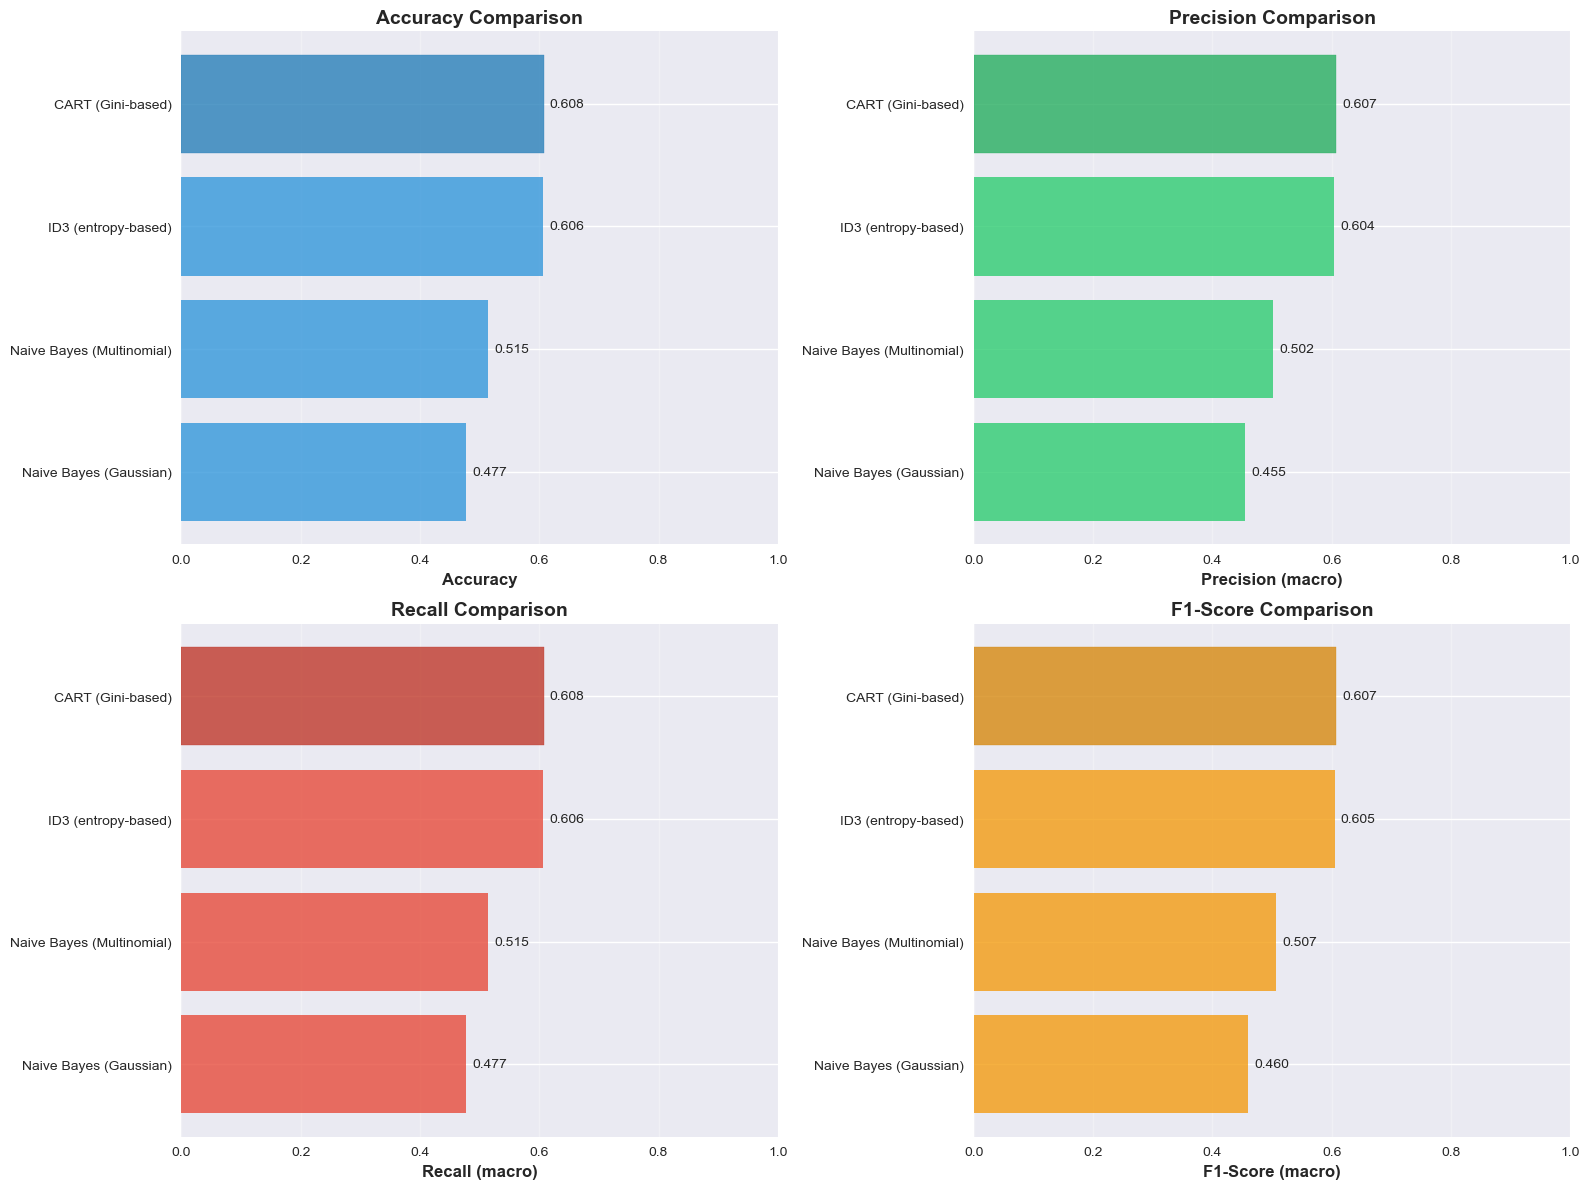

Saved: model_comparison_metrics.png

VISUALIZATION 2: GROUPED METRICS


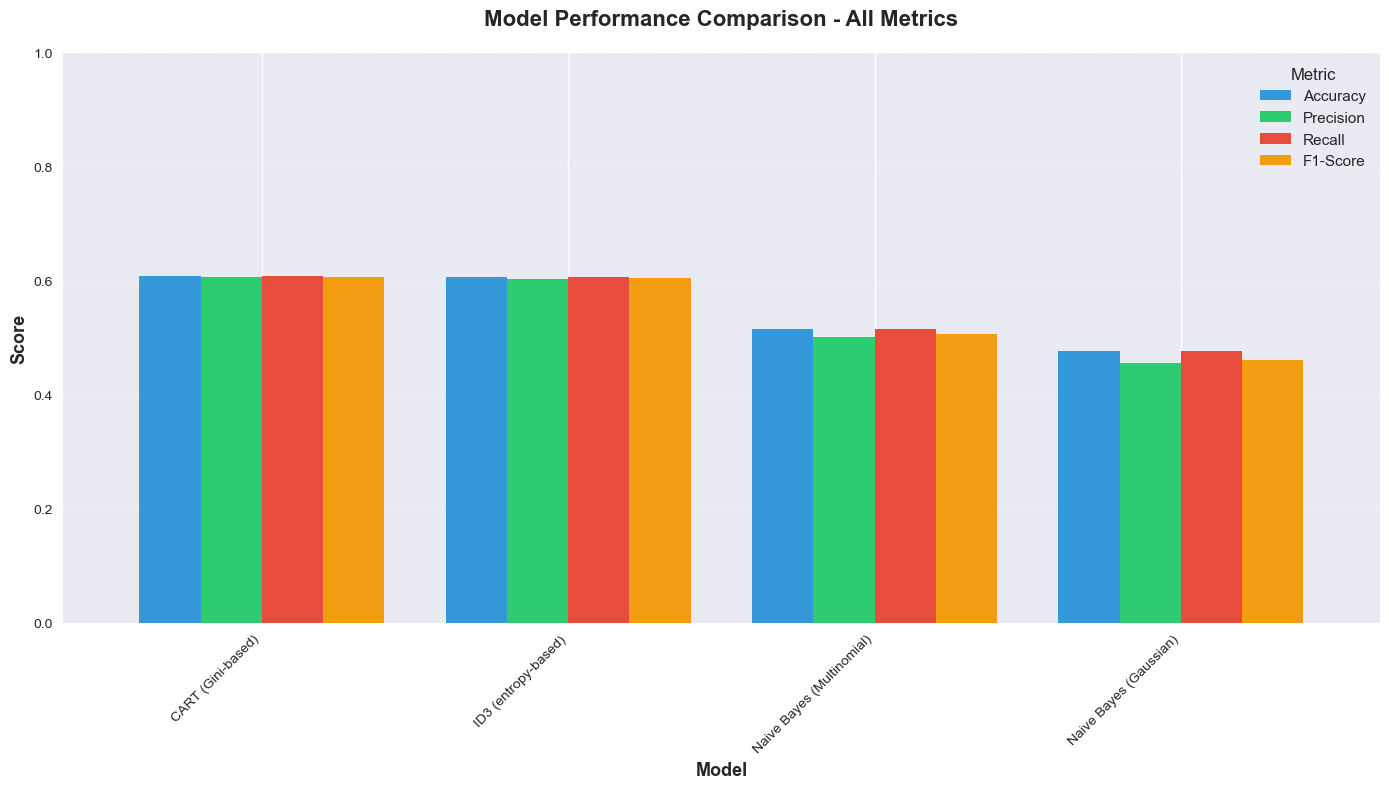

Saved: model_comparison_grouped.png

VISUALIZATION 3: RADAR CHART


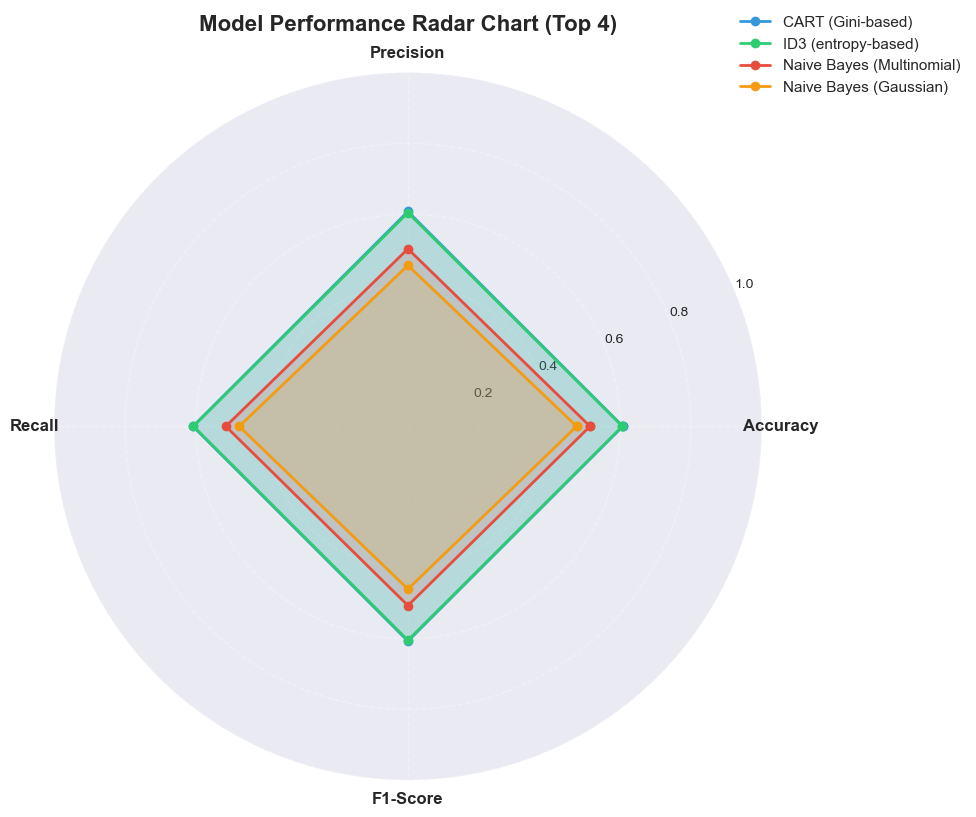

Saved: model_comparison_radar.png

VISUALIZATION 4: PERFORMANCE vs SPEED


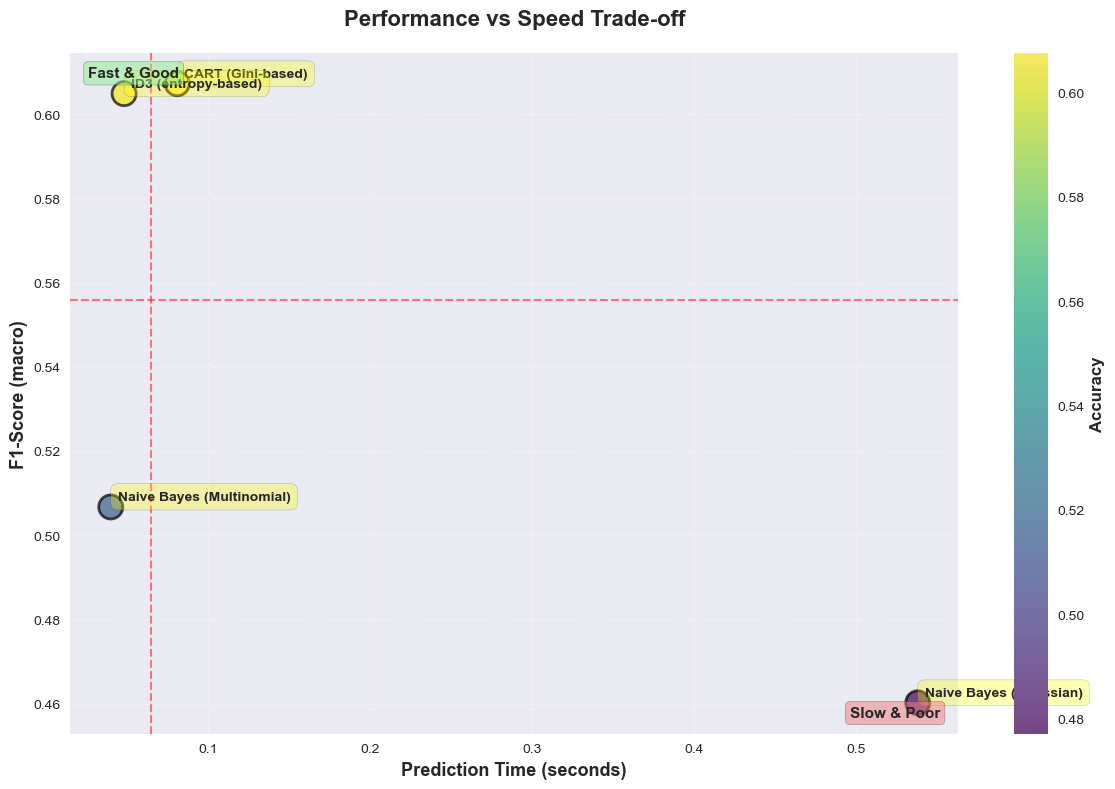

Saved: model_comparison_speed.png

VISUALIZATION 5: METRICS HEATMAP


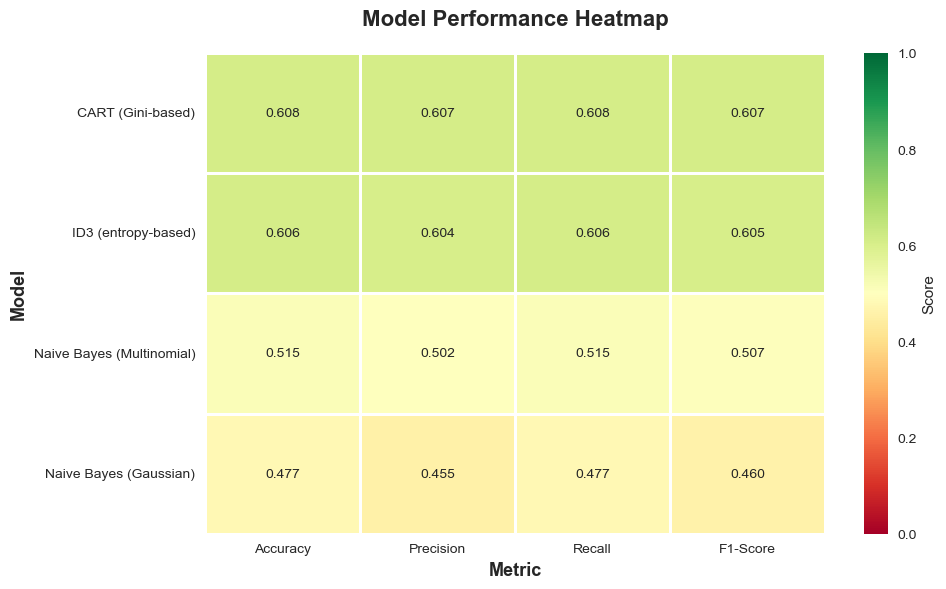

Saved: model_comparison_heatmap.png

STATISTICAL ANALYSIS

Descriptive Statistics:
       accuracy  precision_macro  recall_macro  f1_macro
count  4.000000         4.000000      4.000000  4.000000
mean   0.551458         0.542041      0.551458  0.544748
std    0.065873         0.075964      0.065873  0.073304
min    0.477100         0.454982      0.477100  0.460182
25%    0.505450         0.490079      0.505450  0.495066
50%    0.560567         0.552898      0.560567  0.555789
75%    0.606575         0.604859      0.606575  0.605472
max    0.607600         0.607387      0.607600  0.607232

--------------------------------------------------------------------------------
Performance Gaps:
--------------------------------------------------------------------------------
Accuracy range: 0.4771 - 0.6076 (gap: 0.1305)
F1-Score range: 0.4602 - 0.6072 (gap: 0.1471)

--------------------------------------------------------------------------------
Model Categories:
-------------------------------

In [35]:
# %% [Model Comparison]
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# ============================================================================
# STEP 1: COLLECT ALL RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("COLLECTING RESULTS FROM ALL MODELS")
print("=" * 80)

# Compile all results
all_results = []

# Decision Trees
if 'res_id3' in locals():
    all_results.append(res_id3)
    print("✓ ID3 results collected")

if 'res_cart' in locals():
    all_results.append(res_cart)
    print("✓ CART results collected")

# Naive Bayes
if 'res_gaussian' in locals():
    all_results.append(res_gaussian)
    print("✓ Gaussian NB results collected")

if 'res_multinomial' in locals():
    all_results.append(res_multinomial)
    print("✓ Multinomial NB results collected")

# SVM
if 'res_svm_linear' in locals():
    all_results.append(res_svm_linear)
    print("✓ Linear SVM results collected")

if 'res_svm_rbf' in locals():
    all_results.append(res_svm_rbf)
    print("✓ RBF SVM results collected")

if 'res_svm_poly' in locals():
    all_results.append(res_svm_poly)
    print("✓ Polynomial SVM results collected")

print(f"\nTotal models to compare: {len(all_results)}")

if len(all_results) == 0:
    print("\n⚠️  ERROR: No models found to compare!")
    print("Please run at least one model before comparison.")
else:
    # Create comparison dataframe
    comparison_results = pd.DataFrame(all_results)
    comparison_results = comparison_results.sort_values('f1_macro', ascending=False)
    
    print("\n" + "=" * 80)
    print("RESULTS SUMMARY (sorted by F1-score)")
    print("=" * 80)
    print(comparison_results.to_string(index=False))

# ============================================================================
# STEP 2: DETAILED METRICS TABLE
# ============================================================================
print("\n" + "=" * 80)
print("DETAILED METRICS COMPARISON")
print("=" * 80)

if len(all_results) > 0:
    # Create detailed table
    detailed_metrics = pd.DataFrame({
        'Model': comparison_results['model'],
        'Accuracy': comparison_results['accuracy'],
        'Precision': comparison_results['precision_macro'],
        'Recall': comparison_results['recall_macro'],
        'F1-Score': comparison_results['f1_macro'],
        'Pred_Time (s)': comparison_results['prediction_time']
    })
    
    # Add rankings
    detailed_metrics['Accuracy_Rank'] = detailed_metrics['Accuracy'].rank(ascending=False).astype(int)
    detailed_metrics['F1_Rank'] = detailed_metrics['F1-Score'].rank(ascending=False).astype(int)
    
    print("\n" + detailed_metrics.to_string(index=False))
    
    # Best model
    best_model_name = comparison_results.iloc[0]['model']
    best_f1 = comparison_results.iloc[0]['f1_macro']
    
    print("\n" + "=" * 80)
    print("BEST MODEL")
    print("=" * 80)
    print(f"Model: {best_model_name}")
    print(f"F1-Score: {best_f1:.4f}")
    print(f"Accuracy: {comparison_results.iloc[0]['accuracy']:.4f}")
    print(f"Precision: {comparison_results.iloc[0]['precision_macro']:.4f}")
    print(f"Recall: {comparison_results.iloc[0]['recall_macro']:.4f}")

# ============================================================================
# STEP 3: VISUALIZATION - Overall Performance Comparison
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION 1: OVERALL PERFORMANCE")
print("=" * 80)

if len(all_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    model_names = comparison_results['model'].values
    
    # Accuracy comparison
    axes[0, 0].barh(model_names, comparison_results['accuracy'], color='#3498db', alpha=0.8)
    axes[0, 0].set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlim([0, 1])
    axes[0, 0].grid(axis='x', alpha=0.3)
    axes[0, 0].invert_yaxis()
    
    # Add value labels
    for i, v in enumerate(comparison_results['accuracy']):
        axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
    
    # Precision comparison
    axes[0, 1].barh(model_names, comparison_results['precision_macro'], color='#2ecc71', alpha=0.8)
    axes[0, 1].set_xlabel('Precision (macro)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Precision Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].grid(axis='x', alpha=0.3)
    axes[0, 1].invert_yaxis()
    
    for i, v in enumerate(comparison_results['precision_macro']):
        axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
    
    # Recall comparison
    axes[1, 0].barh(model_names, comparison_results['recall_macro'], color='#e74c3c', alpha=0.8)
    axes[1, 0].set_xlabel('Recall (macro)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Recall Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlim([0, 1])
    axes[1, 0].grid(axis='x', alpha=0.3)
    axes[1, 0].invert_yaxis()
    
    for i, v in enumerate(comparison_results['recall_macro']):
        axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
    
    # F1-Score comparison
    axes[1, 1].barh(model_names, comparison_results['f1_macro'], color='#f39c12', alpha=0.8)
    axes[1, 1].set_xlabel('F1-Score (macro)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlim([0, 1])
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].invert_yaxis()
    
    for i, v in enumerate(comparison_results['f1_macro']):
        axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)
    
    # Highlight best in each metric
    axes[0, 0].get_children()[0].set_color('#2980b9')
    axes[0, 1].get_children()[0].set_color('#27ae60')
    axes[1, 0].get_children()[0].set_color('#c0392b')
    axes[1, 1].get_children()[0].set_color('#d68910')
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison_metrics.png")

# ============================================================================
# STEP 4: VISUALIZATION - Grouped Bar Chart
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION 2: GROUPED METRICS")
print("=" * 80)

if len(all_results) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    metrics_df = pd.DataFrame({
        'Model': comparison_results['model'],
        'Accuracy': comparison_results['accuracy'],
        'Precision': comparison_results['precision_macro'],
        'Recall': comparison_results['recall_macro'],
        'F1-Score': comparison_results['f1_macro']
    })
    
    metrics_df.set_index('Model').plot(kind='bar', ax=ax, width=0.8, 
                                        color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    
    ax.set_title('Model Performance Comparison - All Metrics', fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel('Score', fontsize=13, fontweight='bold')
    ax.set_xlabel('Model', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.legend(title='Metric', fontsize=11, title_fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.savefig('model_comparison_grouped.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison_grouped.png")

# ============================================================================
# STEP 5: VISUALIZATION - Radar Chart
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION 3: RADAR CHART")
print("=" * 80)

if len(all_results) > 0:
    from math import pi
    
    # Select top 4 models for clarity
    top_models = comparison_results.head(min(4, len(comparison_results)))
    
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    
    for idx, (_, row) in enumerate(top_models.iterrows()):
        values = [row['accuracy'], row['precision_macro'], row['recall_macro'], row['f1_macro']]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['model'], color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.title('Model Performance Radar Chart (Top 4)', fontsize=16, fontweight='bold', pad=30)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    plt.tight_layout()
    plt.savefig('model_comparison_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison_radar.png")

# ============================================================================
# STEP 6: VISUALIZATION - Performance vs Speed Trade-off
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION 4: PERFORMANCE vs SPEED")
print("=" * 80)

if len(all_results) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot: F1-score vs Prediction Time
    scatter = ax.scatter(comparison_results['prediction_time'], 
                        comparison_results['f1_macro'],
                        s=300, 
                        c=comparison_results['accuracy'],
                        cmap='viridis',
                        alpha=0.7,
                        edgecolors='black',
                        linewidth=2)
    
    # Add model labels
    for idx, row in comparison_results.iterrows():
        ax.annotate(row['model'], 
                   (row['prediction_time'], row['f1_macro']),
                   xytext=(5, 5), 
                   textcoords='offset points',
                   fontsize=10,
                   fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    
    ax.set_xlabel('Prediction Time (seconds)', fontsize=13, fontweight='bold')
    ax.set_ylabel('F1-Score (macro)', fontsize=13, fontweight='bold')
    ax.set_title('Performance vs Speed Trade-off', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Accuracy', fontsize=12, fontweight='bold')
    
    # Add quadrant lines
    median_time = comparison_results['prediction_time'].median()
    median_f1 = comparison_results['f1_macro'].median()
    ax.axvline(median_time, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.axhline(median_f1, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Annotate quadrants
    ax.text(0.02, 0.98, 'Fast & Good', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    ax.text(0.98, 0.02, 'Slow & Poor', transform=ax.transAxes, 
            fontsize=11, verticalalignment='bottom', horizontalalignment='right', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('model_comparison_speed.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison_speed.png")

# ============================================================================
# STEP 7: VISUALIZATION - Heatmap of All Metrics
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION 5: METRICS HEATMAP")
print("=" * 80)

if len(all_results) > 0:
    fig, ax = plt.subplots(figsize=(10, max(6, len(all_results) * 0.8)))
    
    # Prepare data for heatmap
    heatmap_data = comparison_results[['model', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']].copy()
    heatmap_data = heatmap_data.set_index('model')
    heatmap_data.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, linewidths=2, linecolor='white',
                cbar_kws={'label': 'Score'}, ax=ax)
    
    ax.set_title('Model Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Metric', fontsize=13, fontweight='bold')
    ax.set_ylabel('Model', fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_comparison_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: model_comparison_heatmap.png")

# ============================================================================
# STEP 8: STATISTICAL ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("STATISTICAL ANALYSIS")
print("=" * 80)

if len(all_results) > 0:
    print("\nDescriptive Statistics:")
    stats_df = comparison_results[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']].describe()
    print(stats_df.to_string())
    
    print("\n" + "-" * 80)
    print("Performance Gaps:")
    print("-" * 80)
    
    best_acc = comparison_results['accuracy'].max()
    worst_acc = comparison_results['accuracy'].min()
    print(f"Accuracy range: {worst_acc:.4f} - {best_acc:.4f} (gap: {best_acc - worst_acc:.4f})")
    
    best_f1 = comparison_results['f1_macro'].max()
    worst_f1 = comparison_results['f1_macro'].min()
    print(f"F1-Score range: {worst_f1:.4f} - {best_f1:.4f} (gap: {best_f1 - worst_f1:.4f})")
    
    print("\n" + "-" * 80)
    print("Model Categories:")
    print("-" * 80)
    
    # Categorize models
    mean_f1 = comparison_results['f1_macro'].mean()
    std_f1 = comparison_results['f1_macro'].std()
    
    excellent = comparison_results[comparison_results['f1_macro'] >= mean_f1 + 0.5 * std_f1]
    good = comparison_results[(comparison_results['f1_macro'] >= mean_f1 - 0.5 * std_f1) & 
                             (comparison_results['f1_macro'] < mean_f1 + 0.5 * std_f1)]
    poor = comparison_results[comparison_results['f1_macro'] < mean_f1 - 0.5 * std_f1]
    
    if len(excellent) > 0:
        print(f"\nExcellent models (F1 ≥ {mean_f1 + 0.5 * std_f1:.3f}):")
        for model in excellent['model']:
            print(f"  - {model}")
    
    if len(good) > 0:
        print(f"\nGood models ({mean_f1 - 0.5 * std_f1:.3f} ≤ F1 < {mean_f1 + 0.5 * std_f1:.3f}):")
        for model in good['model']:
            print(f"  - {model}")
    
    if len(poor) > 0:
        print(f"\nPoor models (F1 < {mean_f1 - 0.5 * std_f1:.3f}):")
        for model in poor['model']:
            print(f"  - {model}")

# ============================================================================
# STEP 9: RECOMMENDATIONS
# ============================================================================
print("\n" + "=" * 80)
print("RECOMMENDATIONS")
print("=" * 80)

if len(all_results) > 0:
    best_overall = comparison_results.iloc[0]
    fastest = comparison_results.loc[comparison_results['prediction_time'].idxmin()]
    most_balanced = comparison_results.loc[
        (comparison_results['precision_macro'] - comparison_results['recall_macro']).abs().idxmin()
    ]
    
    print("\nBest Overall Performance:")
    print(f"  Model: {best_overall['model']}")
    print(f"  F1-Score: {best_overall['f1_macro']:.4f}")
    print(f"  Reason: Highest F1-score among all models")
    
    print("\nFastest Model:")
    print(f"  Model: {fastest['model']}")
    print(f"  Prediction Time: {fastest['prediction_time']:.4f}s")
    print(f"  F1-Score: {fastest['f1_macro']:.4f}")
    print(f"  Reason: Fastest prediction time with F1 = {fastest['f1_macro']:.4f}")
    
    print("\nMost Balanced Model:")
    print(f"  Model: {most_balanced['model']}")
    print(f"  Precision: {most_balanced['precision_macro']:.4f}")
    print(f"  Recall: {most_balanced['recall_macro']:.4f}")
    print(f"  Gap: {abs(most_balanced['precision_macro'] - most_balanced['recall_macro']):.4f}")
    print(f"  Reason: Smallest gap between precision and recall")
    
    print("\n" + "-" * 80)
    print("Final Recommendation:")
    print("-" * 80)
    
    if best_overall['f1_macro'] >= 0.6:
        print(f"✓ Use {best_overall['model']} for best overall performance")
    elif fastest['f1_macro'] >= 0.5 and fastest['prediction_time'] < 0.1:
        print(f"✓ Use {fastest['model']} for fast predictions with acceptable performance")
    else:
        print(f"⚠️  All models have F1 < 0.6. Consider:")
        print("  - Feature engineering")
        print("  - More training data")
        print("  - Ensemble methods")
        print("  - Different problem formulation")

# ============================================================================
# STEP 10: EXPORT RESULTS
# ============================================================================
print("\n" + "=" * 80)
print("EXPORTING RESULTS")
print("=" * 80)

if len(all_results) > 0:
    # Save detailed results to CSV
    comparison_results.to_csv('model_comparison_results.csv', index=False)
    print("✓ Saved: model_comparison_results.csv")
    
    # Save summary report
    with open('model_comparison_report.txt', 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("MODEL COMPARISON REPORT\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("SUMMARY TABLE:\n")
        f.write(comparison_results.to_string(index=False))
        f.write("\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("BEST MODEL\n")
        f.write("=" * 80 + "\n")
        f.write(f"Model: {best_overall['model']}\n")
        f.write(f"Accuracy: {best_overall['accuracy']:.4f}\n")
        f.write(f"Precision: {best_overall['precision_macro']:.4f}\n")
        f.write(f"Recall: {best_overall['recall_macro']:.4f}\n")
        f.write(f"F1-Score: {best_overall['f1_macro']:.4f}\n")
        f.write(f"Prediction Time: {best_overall['prediction_time']:.4f}s\n")
    
    print("✓ Saved: model_comparison_report.txt")

print("\n" + "=" * 80)
print("MODEL COMPARISON COMPLETE")
print("=" * 80)

if len(all_results) > 0:
    print(f"\nTotal models compared: {len(all_results)}")
    print(f"Best model: {best_overall['model']}")
    print(f"Best F1-Score: {best_overall['f1_macro']:.4f}")
    print("\nGenerated files:")
    print("  - model_comparison_metrics.png")
    print("  - model_comparison_grouped.png")
    print("  - model_comparison_radar.png")
    print("  - model_comparison_speed.png")
    print("  - model_comparison_heatmap.png")
    print("  - model_comparison_results.csv")
    print("  - model_comparison_report.txt")